***전력 사용량 데이터 EDA***
 - 건물 정보와 기후 정보를 활용한 전력사용량 예측 



## 데이터, 라이브러리 불러오기

In [50]:
import numpy as np
import pandas as pd

# EDA
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn

from scipy.stats import spearmanr

In [16]:
train = pd.read_csv('./energy/train.csv', encoding = 'cp949')
test = pd.read_csv('./energy/test.csv', encoding = 'cp949')

In [17]:
train.head()

num      date_time  전력사용량(kWh)  기온(°C)  풍속(m/s)  습도(%)  강수량(mm)  일조(hr)  \
0    1  2020-06-01 00    8179.056    17.6      2.5   92.0      0.8     0.0   
1    1  2020-06-01 01    8135.640    17.7      2.9   91.0      0.3     0.0   
2    1  2020-06-01 02    8107.128    17.5      3.2   91.0      0.0     0.0   
3    1  2020-06-01 03    8048.808    17.1      3.2   91.0      0.0     0.0   
4    1  2020-06-01 04    8043.624    17.0      3.3   92.0      0.0     0.0   

   비전기냉방설비운영  태양광보유  
0        0.0    0.0  
1        0.0    0.0  
2        0.0    0.0  
3        0.0    0.0  
4        0.0    0.0

In [4]:
test.head()

num      date_time  기온(°C)  풍속(m/s)  습도(%)  강수량(mm, 6시간)  일조(hr, 3시간)  \
0    1  2020-08-25 00    27.8      1.5   74.0           0.0          0.0   
1    1  2020-08-25 01     NaN      NaN    NaN           NaN          NaN   
2    1  2020-08-25 02     NaN      NaN    NaN           NaN          NaN   
3    1  2020-08-25 03    27.3      1.1   78.0           NaN          0.0   
4    1  2020-08-25 04     NaN      NaN    NaN           NaN          NaN   

   비전기냉방설비운영  태양광보유  
0        NaN    NaN  
1        NaN    NaN  
2        NaN    NaN  
3        NaN    NaN  
4        NaN    NaN

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   num         122400 non-null  int64  
 1   date_time   122400 non-null  object 
 2   전력사용량(kWh)  122400 non-null  float64
 3   기온(°C)      122400 non-null  float64
 4   풍속(m/s)     122400 non-null  float64
 5   습도(%)       122400 non-null  float64
 6   강수량(mm)     122400 non-null  float64
 7   일조(hr)      122400 non-null  float64
 8   비전기냉방설비운영   122400 non-null  float64
 9   태양광보유       122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num           10080 non-null  int64  
 1   date_time     10080 non-null  object 
 2   기온(°C)        3360 non-null   float64
 3   풍속(m/s)       3360 non-null   float64
 4   습도(%)         3360 non-null   float64
 5   강수량(mm, 6시간)  1680 non-null   float64
 6   일조(hr, 3시간)   3360 non-null   float64
 7   비전기냉방설비운영     2296 non-null   float64
 8   태양광보유         1624 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 708.9+ KB


## EDA

In [18]:
# column명 한글에서 영어로 변경
train.columns = ['num','datetime','target','temp','windspeed','humidity','precipitation','insolation','nelec_cool_flag','solar_flag']
test.columns = ['num','datetime','temp','windspeed','humidity','precipitation','insolation','nelec_cool_flag','solar_flag']

In [19]:
df = train.copy()

In [9]:
df.head()

num       datetime    target  temp  windspeed  humidity  precipitation  \
0    1  2020-06-01 00  8179.056  17.6        2.5      92.0            0.8   
1    1  2020-06-01 01  8135.640  17.7        2.9      91.0            0.3   
2    1  2020-06-01 02  8107.128  17.5        3.2      91.0            0.0   
3    1  2020-06-01 03  8048.808  17.1        3.2      91.0            0.0   
4    1  2020-06-01 04  8043.624  17.0        3.3      92.0            0.0   

   insolation  nelec_cool_flag  solar_flag  
0         0.0              0.0         0.0  
1         0.0              0.0         0.0  
2         0.0              0.0         0.0  
3         0.0              0.0         0.0  
4         0.0              0.0         0.0

datetime을 여러 요소별로 확인하기 위해 hour, weekday, date, day, month, weekend로 나눈뒤 피쳐 추가

In [20]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['hour'] = df['datetime'].dt.hour
df['weekday'] = df['datetime'].dt.weekday
df['date'] = df['datetime'].dt.date
df['day'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['weekend'] = df['weekday'].isin([5,6]).astype(int)

In [11]:
df.tail()

num            datetime    target  temp  windspeed  humidity  \
122395   60 2020-08-24 19:00:00  4114.368  27.8        2.3      68.0   
122396   60 2020-08-24 20:00:00  3975.696  27.3        1.2      71.0   
122397   60 2020-08-24 21:00:00  3572.208  27.3        1.8      71.0   
122398   60 2020-08-24 22:00:00  3299.184  27.1        1.8      74.0   
122399   60 2020-08-24 23:00:00  3204.576  27.1        2.6      75.0   

        precipitation  insolation  nelec_cool_flag  solar_flag  hour  weekday  \
122395            0.0         0.7              1.0         1.0    19        0   
122396            0.0         0.0              1.0         1.0    20        0   
122397            0.0         0.0              1.0         1.0    21        0   
122398            0.0         0.0              1.0         1.0    22        0   
122399            0.0         0.0              1.0         1.0    23        0   

              date  day  month  weekend  
122395  2020-08-24   24      8        0  
122396  2020-08-24   24      8        0  
122397  2020-08-24   24      8        0  
122398  2020-08-24   24      8        0  
122399  2020-08-24   24      8        0

### Target과 다른 요소들과의 분포

In [12]:
sns.set_style('whitegrid')

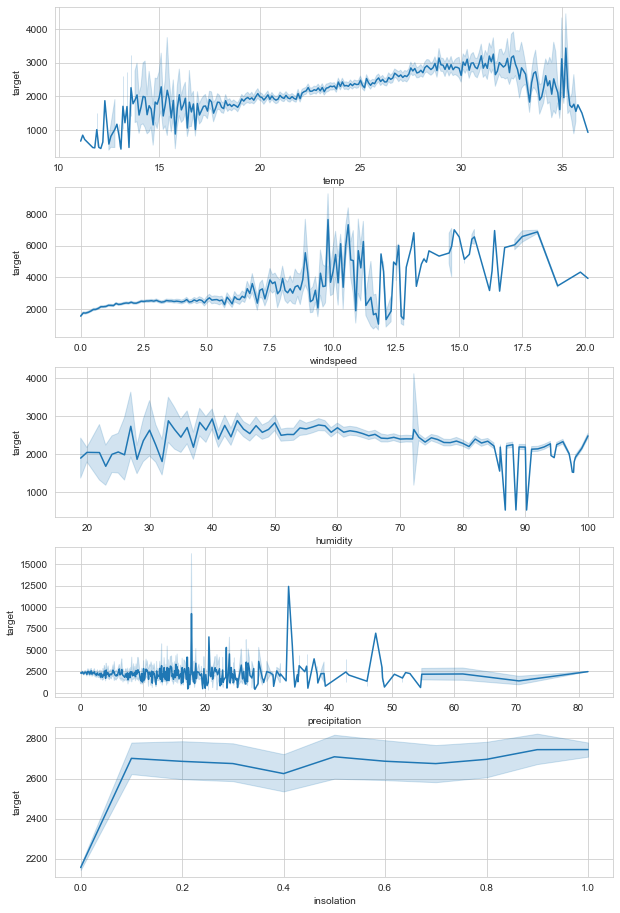

In [13]:
# temp, windspeed, humidity, precipitation, insolation와 target과의 관계
plt.figure(figsize=(10,16))
for i in range(5):
    plt.subplot(5,1,i+1)
    sns.lineplot(x=df[df.columns[i+3]], y=df['target'])

temp, windspeed는 값이 커질수록 target값인 전력사용량과의 비례적인 경향을 보이지만 단지 그래프로는 판별하기에 무리가 있다.

### 각 건물별 요일, 시간 별 전력 사용량

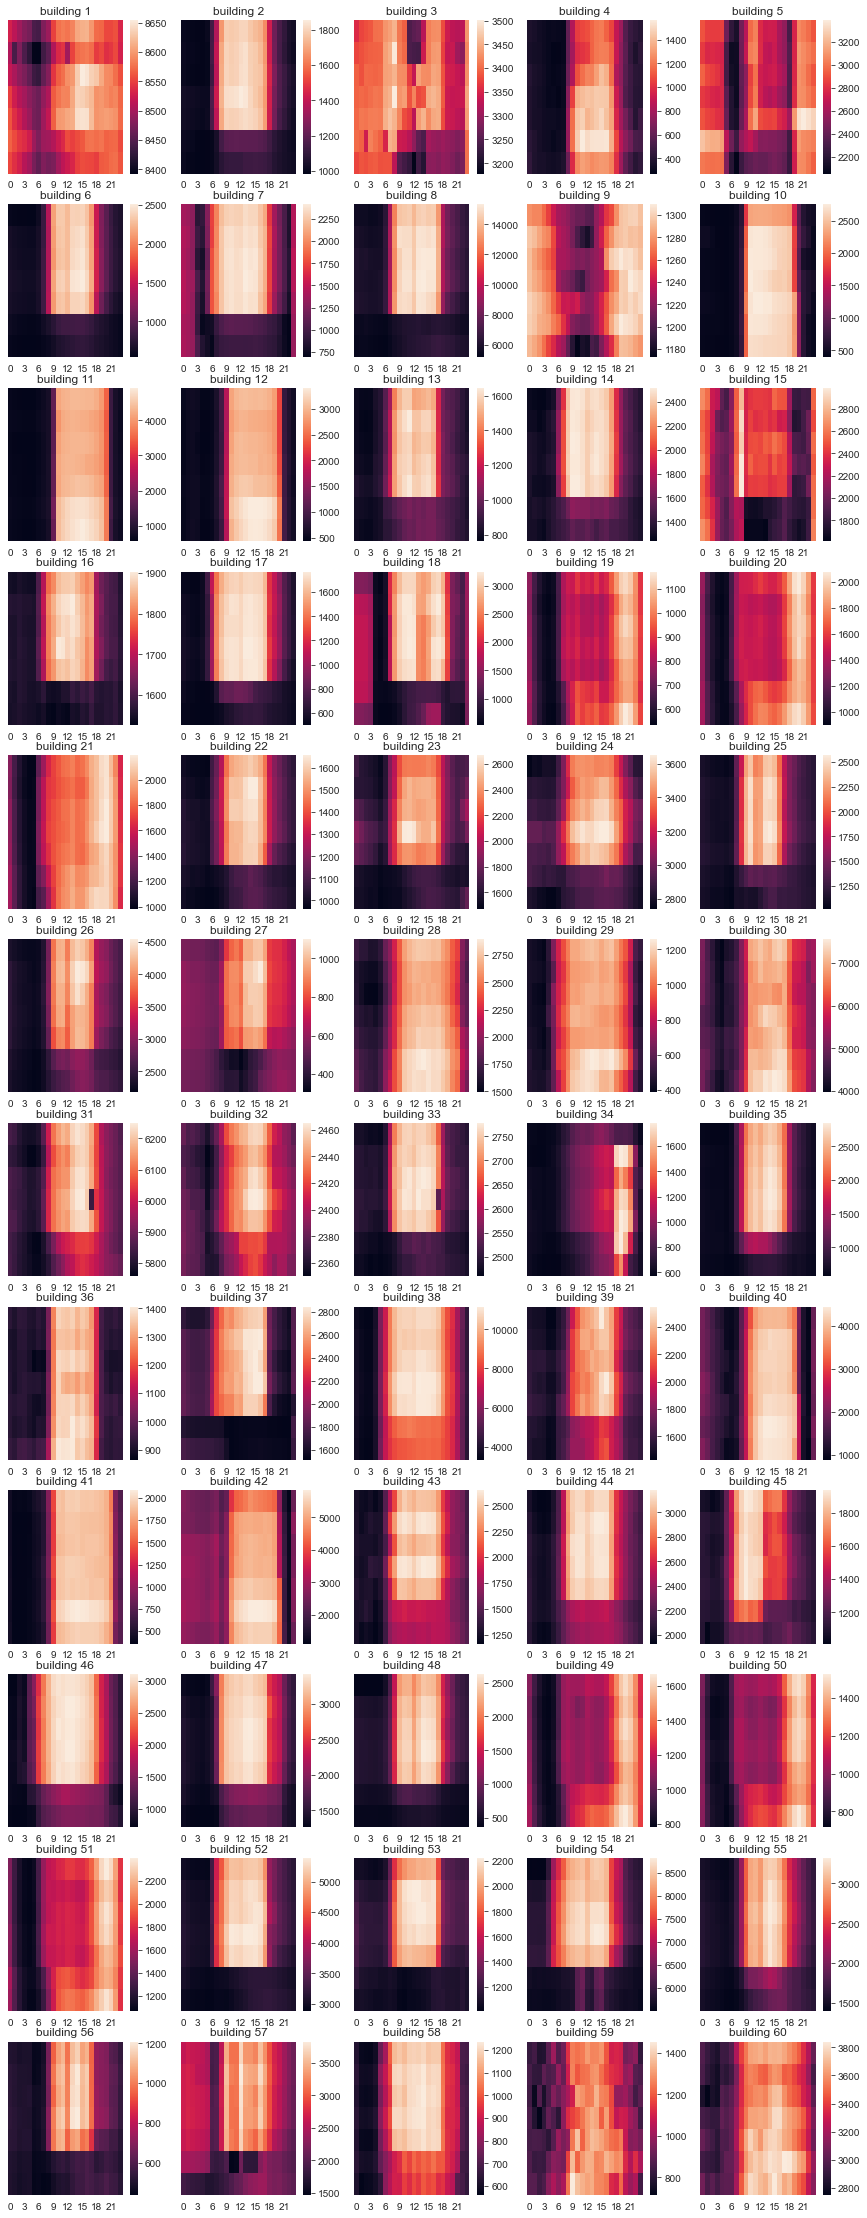

In [44]:
# weekday, hour별 건물들의 에너지 사용량
fig = plt.figure(figsize = (15, 40))
for num in df['num'].unique():
    data = df[df.num == num]
    data = data.groupby(['weekday', 'hour'])['target'].mean().reset_index().pivot('weekday', 'hour', 'target')
    plt.subplot(12, 5, num)
    sns.heatmap(data)
    plt.title(f'building {num}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

시간과 요일별로 비슷한 양상을 보이는 건물 부류들을 확인

## 군집화

### GMM 알고리즘 군집화

In [14]:
by_weekday = df.groupby(['num','weekday'])['target'].median().reset_index().pivot('num','weekday','target').reset_index()
by_hour = df.groupby(['num','hour'])['target'].median().reset_index().pivot('num','hour','target').reset_index().drop('num', axis = 1)
data = pd.concat([by_weekday, by_hour], axis= 1)
columns = ['num'] + ['day'+str(i) for i in range(7)] + ['hour'+str(i) for i in range(24)]
data.columns = columns

In [15]:
for i in range(len(data)):
    # 요일 별 전력 중앙값에 대해 scaling
    data.iloc[i,1:8] = (data.iloc[i,1:8] - data.iloc[i,1:8].mean())/data.iloc[i,1:8].std()
    # 시간대별 전력 중앙값에 대해 scaling
    data.iloc[i,8:] = (data.iloc[i,8:] - data.iloc[i,8:].mean())/data.iloc[i,8:].std()

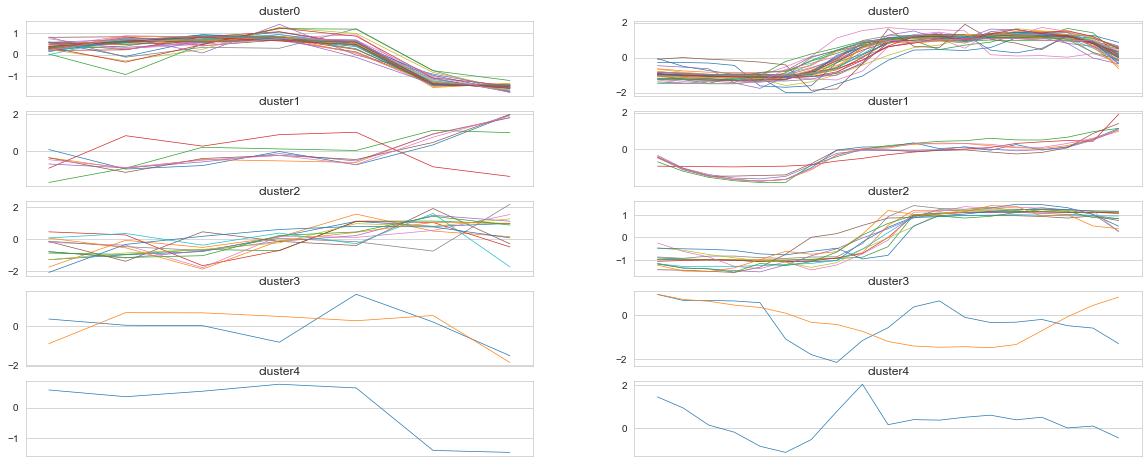

In [16]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=5, random_state=32)
gmm_cluster = gmm.fit_predict(data.iloc[:,1:])

# 클러스터링 결과를 irisDF 의 'gmm_cluster' 컬럼명으로 저장
data_gmm = data.copy()
data_gmm['gmm'] = gmm_cluster

# target 값에 따라서 gmm_cluster 값이 어떻게 매핑되었는지 확인. 
n_c = len(np.unique(data_gmm.gmm)) 

fig = plt.figure(figsize = (20,8))
for c in range(n_c):
    temp = data_gmm[data_gmm.gmm == c]
    plt.subplot(n_c,2,2*c+1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,1:8], linewidth=0.7 )
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])
    plt.subplot(n_c,2,2*c+2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,8:-6], linewidth=0.7)
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])

In [17]:
df = df.merge(data_gmm[['num','gmm']], on = 'num', how = 'left')

### Hierarchical 알고리즘 군집화

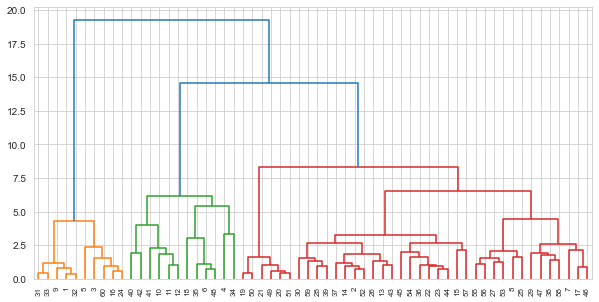

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

# Power consumption by day/3 hours of a specific building
fig = plt.figure(figsize=(10,5))
df['hour_by3'] = df['datetime'].apply(lambda x: str(x.hour//3*3).zfill(2))
agg_cl = df.groupby(['num', 'hour_by3', 'day'])['target'].median().reset_index()
agg_cl['R'] = agg_cl.groupby('num')['target'].apply(lambda x: x/x.max())
dt_cl = agg_cl.pivot_table(index='num', columns=['day', 'hour_by3'], values='R')

# Hierarchical clustering and visualization
dist_building = pdist(dt_cl.values)
hc_building = linkage(dist_building, method='ward')

dendrogram(hc_building, labels=dt_cl.index, leaf_rotation=90, leaf_font_size=8)
plt.show()

크게 5가지 그룹으로 나뉘어 지는 것을 확인

In [22]:
from scipy.cluster.hierarchy import fcluster
clusters =  pd.DataFrame({'num': range(1, 61), 'cluster':  fcluster(hc_building, t=5, criterion='maxclust')})

In [23]:
df = pd.merge(df, clusters, on='num', how='left')

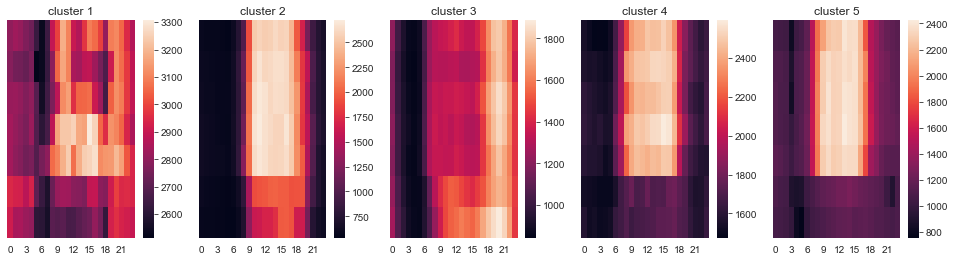

In [29]:
fig = plt.figure(figsize = (20, 4))
for c in range(1,6):
    temp = df[df.cluster == c]
    temp = temp.groupby(['weekday', 'hour'])['target'].median().reset_index().pivot('weekday', 'hour', 'target')
    plt.subplot(1, 6, c+1)
    sns.heatmap(temp)
    plt.title(f'cluster {c}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

In [18]:
# dictionary mapping cluster and building
match = data_gmm[['num','gmm']]
clust_to_num = {0:[],1:[],2:[],3:[],4:[]}
for i in range(60):
    c = match.iloc[i,1]
    clust_to_num[c].append(i+1)

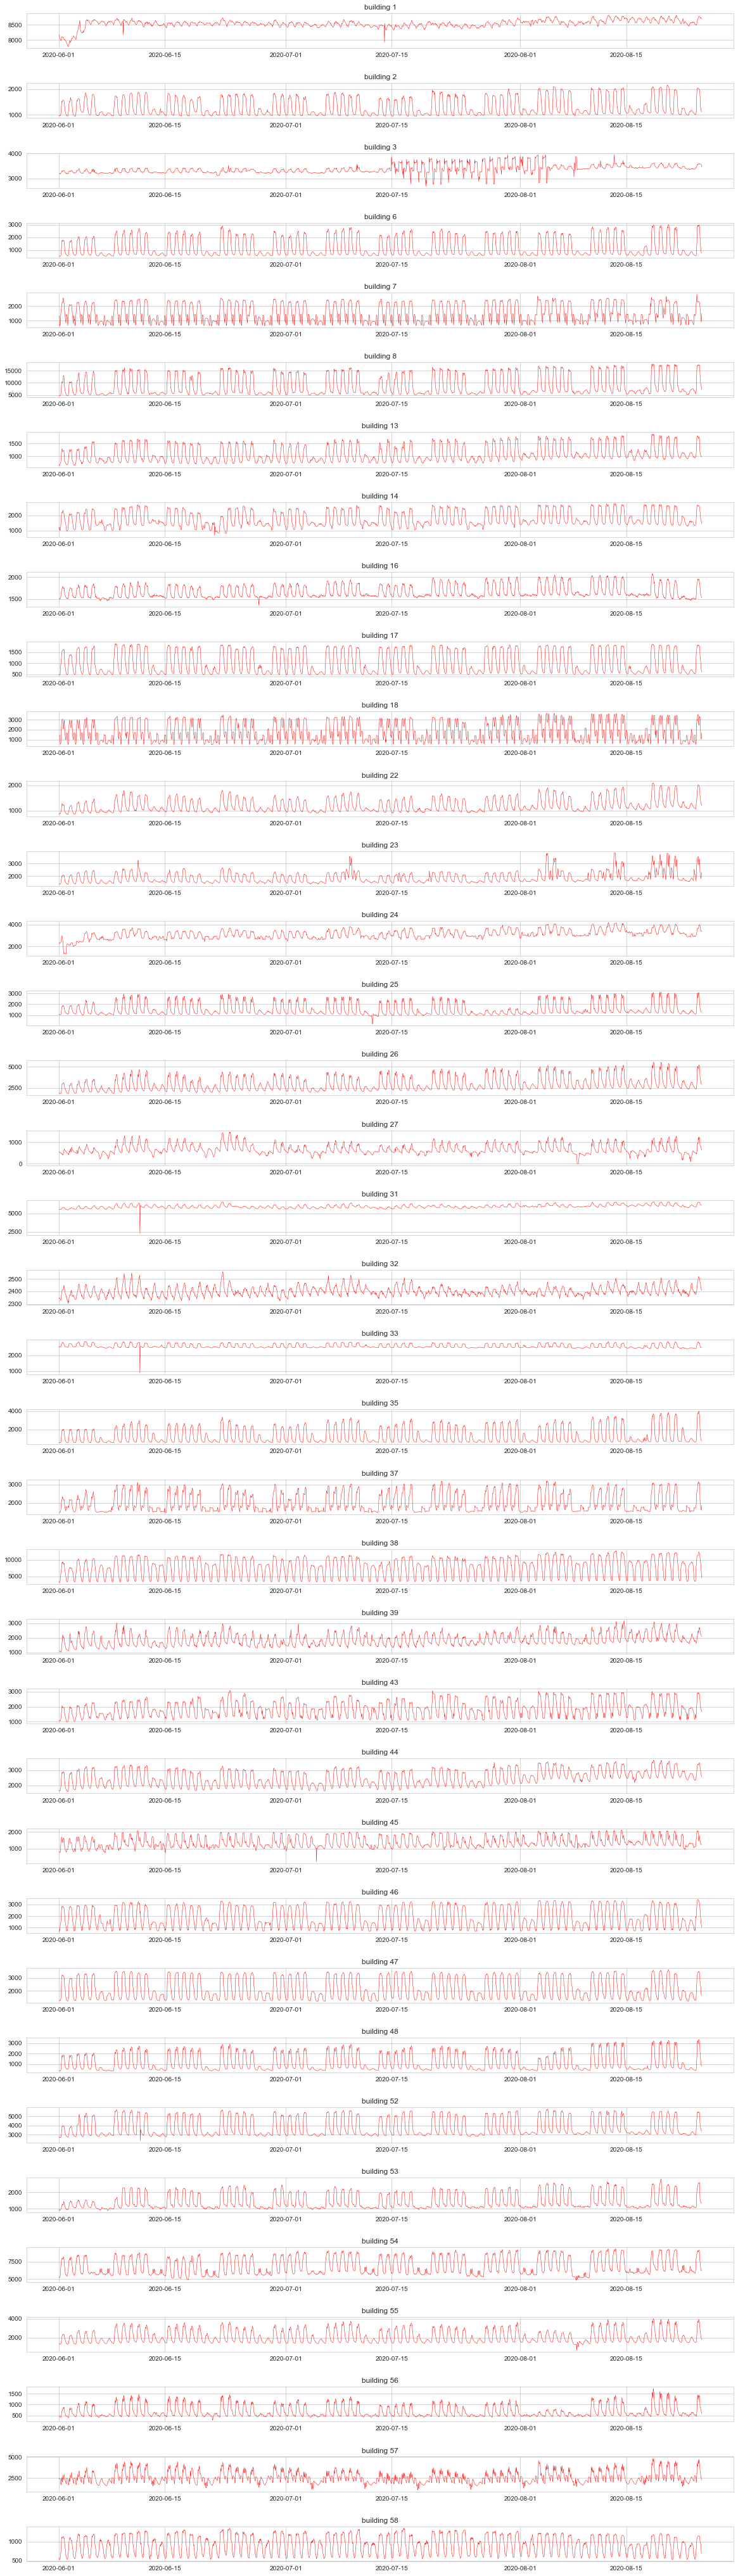

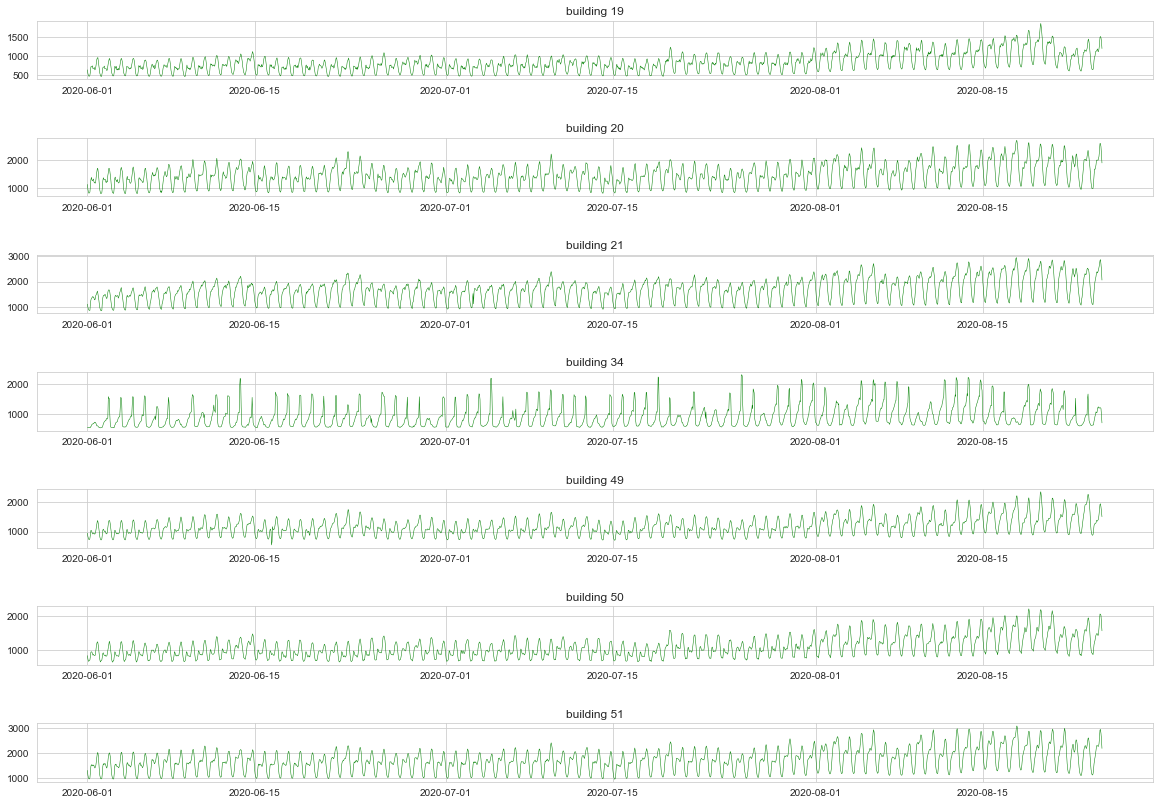

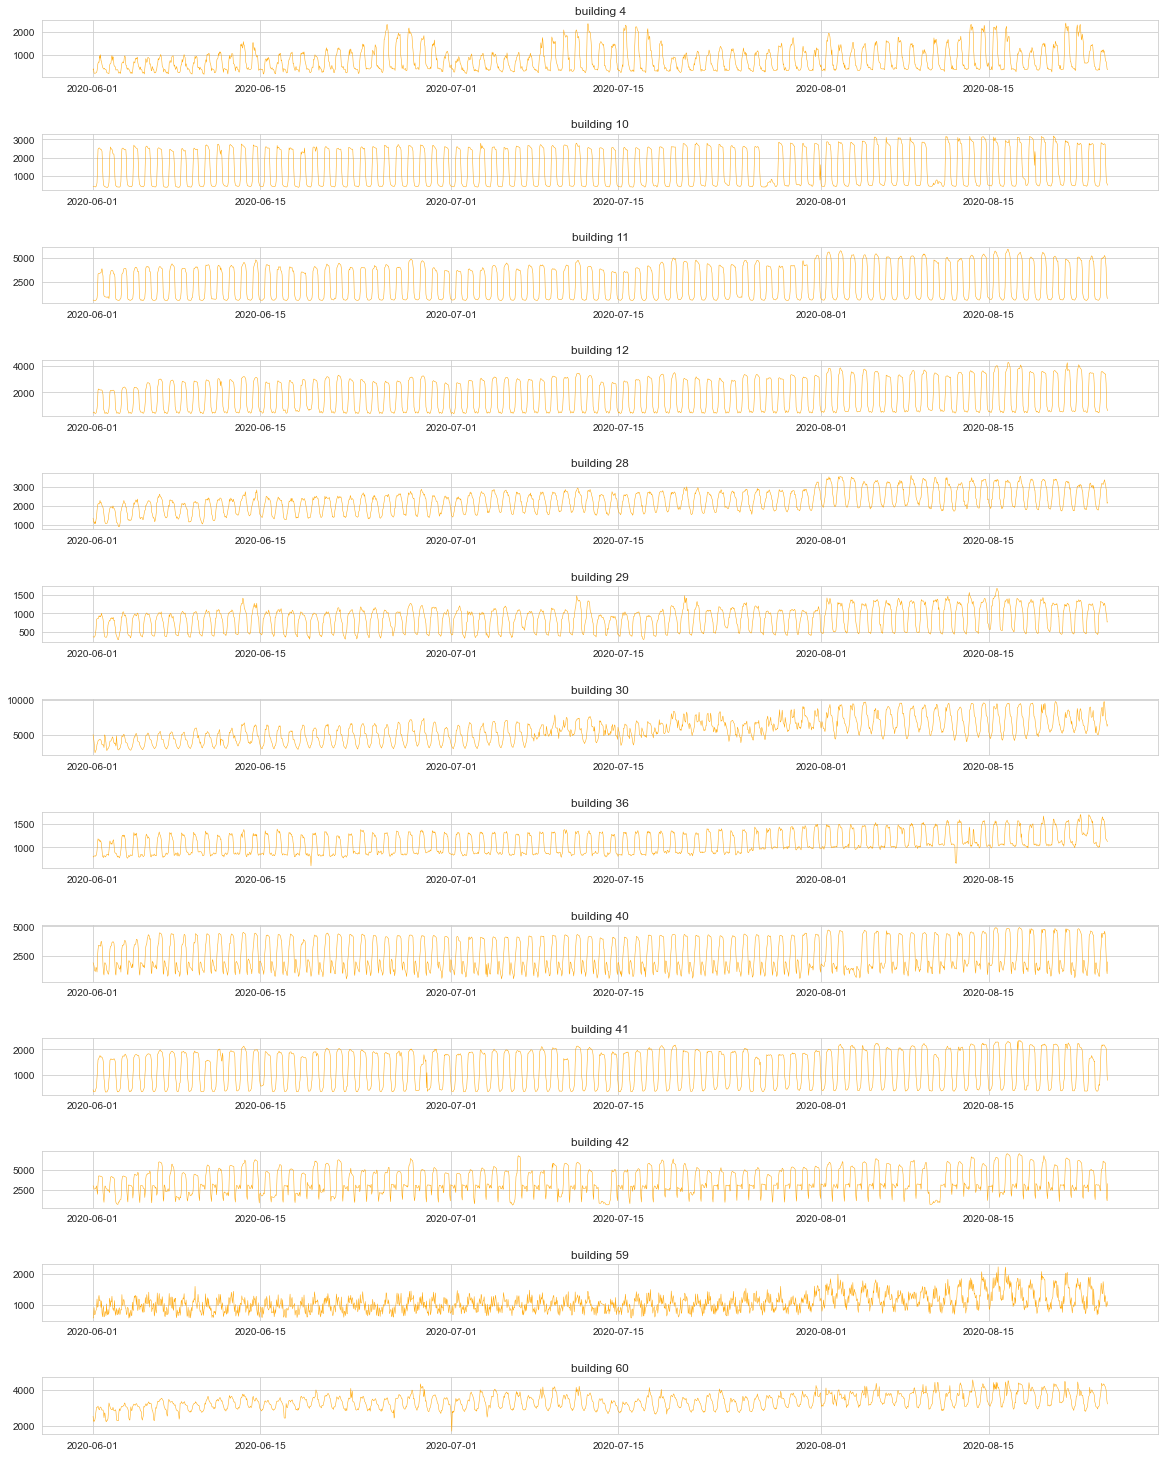

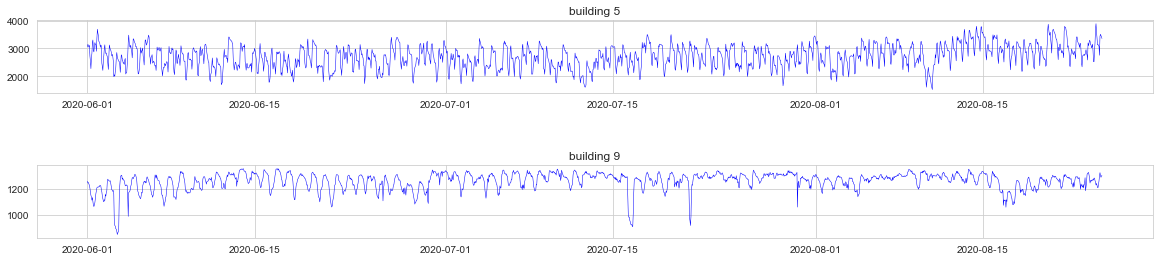

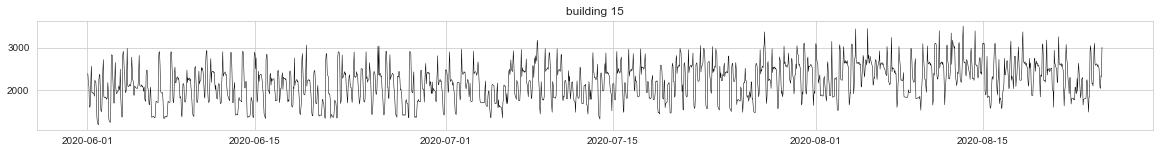

In [19]:
# linplot(energy usage of each building ~ cluster, datetime)
for c, col in enumerate(['red','green','orange','blue','black']):
    temp_1 = df[df.gmm == c]
    nums = np.unique(temp_1.num)
    n_nums = len(nums)
    fig = plt.figure(figsize = (20, 2*n_nums))
    for i, num in enumerate(nums):
        temp_2 = temp_1[temp_1.num == num]
        plt.subplot(n_nums,1, i+1)
        sns.lineplot(data = temp_2, x= 'datetime', y = 'target', linewidth = 0.5, color = col)
        plt.title(f'building {num}')
        plt.subplots_adjust(hspace = 1)
        plt.ylabel('')
        plt.xlabel('')

In [22]:
# cluster 0
df_0 = df[df.gmm == 0]
df_0 = df_0.groupby(['num','date'])['temp','humidity','windspeed','insolation','precipitation','target'].mean().reset_index()
corrs_0 = []
for num in clust_to_num[0]:
    corr = []
    corr.append(num)
    for feat in ['temp','humidity','windspeed','insolation','precipitation']:
        corr.append(spearmanr(df_0.loc[df_0.num == num, feat], df_0.loc[df_0.num == num, 'target']).correlation)
    corrs_0.append(corr)
# cluster 1
df_1 = df[df.gmm == 1]
df_1 = df_1.groupby(['num','date'])['temp','humidity','windspeed','insolation','precipitation','target'].mean().reset_index()
corrs_1 = []
for num in clust_to_num[1]:
    corr = []
    corr.append(num)
    for feat in ['temp','humidity','windspeed','insolation','precipitation']:
        corr.append(spearmanr(df_1.loc[df_1.num == num, feat], df_1.loc[df_1.num == num, 'target']).correlation)
    corrs_1.append(corr)
# cluster 2
df_2 = df[df.gmm == 2]
df_2 = df_2.groupby(['num','date'])['temp','humidity','windspeed','insolation','precipitation','target'].mean().reset_index()
corrs_2 = []
for num in clust_to_num[2]:
    corr = []
    corr.append(num)
    for feat in ['temp','humidity','windspeed','insolation','precipitation']:
        corr.append(spearmanr(df_2.loc[df_2.num == num, feat], df_2.loc[df_2.num == num, 'target']).correlation)
    corrs_2.append(corr)
# cluster 3
df_3 = df[df.gmm == 3]
df_3 = df_3.groupby(['num','date'])['temp','humidity','windspeed','insolation','precipitation','target'].mean().reset_index()
corrs_3 = []
for num in clust_to_num[3]:
    corr = []
    corr.append(num)
    for feat in ['temp','humidity','windspeed','insolation','precipitation']:
        corr.append(spearmanr(df_3.loc[df_3.num == num, feat], df_3.loc[df_3.num == num, 'target']).correlation)
    corrs_3.append(corr)
# cluster 4
df_4 = df[df.gmm == 4]
df_4 = df_4.groupby(['num','date'])['temp','humidity','windspeed','insolation','precipitation','target'].mean().reset_index()
corrs_4 = []
for num in clust_to_num[4]:
    corr = []
    corr.append(num)
    for feat in ['temp','humidity','windspeed','insolation','precipitation']:
        corr.append(spearmanr(df_4.loc[df_4.num == num, feat], df_4.loc[df_4.num == num, 'target']).correlation)
    corrs_4.append(corr)
corrs_total = [corrs_0, corrs_1, corrs_2, corrs_3, corrs_4]

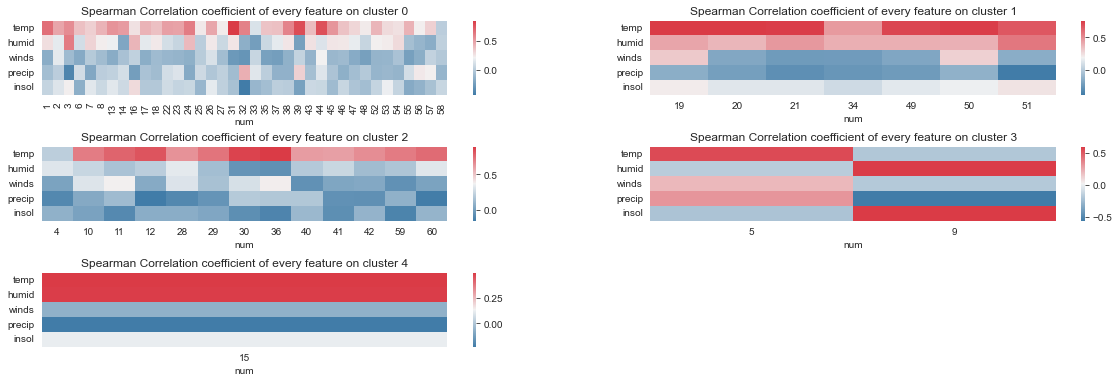

In [25]:
fig = plt.figure(figsize = (20, 6))
for i, corrs in enumerate(corrs_total):    
    corr_df = pd.DataFrame(np.array(corrs), columns = ['num','temp','humid','winds','precip','insol'])
    corr_df['num'] = corr_df['num'].astype(int)
    corr_df = corr_df.set_index('num')

    plt.subplot(3,2,i+1)
    sns.heatmap(corr_df.transpose(), cmap=sns.diverging_palette(240,10,as_cmap=True))
    plt.subplots_adjust(hspace = 0.7)
    plt.title(f'Spearman Correlation coefficient of every feature on cluster {i}')

cluster 0는 

[불쾌지수=1.8x기온–0.55x(1–습도)x(1.8x기온–26)+32]

In [34]:
solar_df = df.loc[df.solar_flag == 1.0]

C:\Users\psw\AppData\Local\Temp/ipykernel_6660/1897667428.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  s_df = solar_df.groupby(['num','weekend','date'])['insolation','target'].mean().reset_index()
C:\tools\Anaconda3\lib\site-packages\seaborn\regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\seaborn\regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


<Figure size 1080x1800 with 0 Axes>

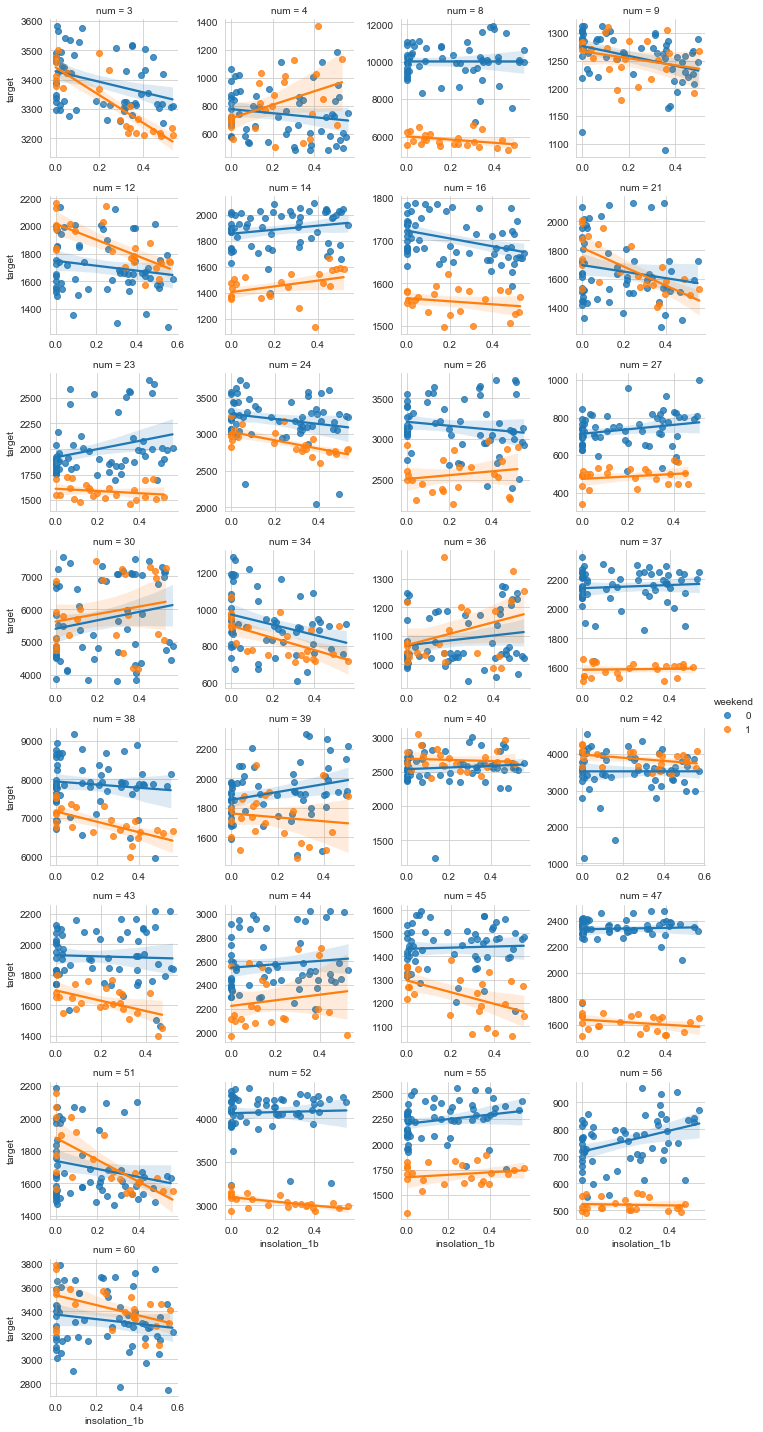

In [35]:
s_df = solar_df.groupby(['num','weekend','date'])['insolation','target'].mean().reset_index()
s_df['insolation_1b'] = s_df['insolation'].shift(1)
s_df['insolation_2b'] = s_df['insolation'].shift(2)
s_df['insolation_3b'] = s_df['insolation'].shift(3)
s_df['insolation_1c'] = s_df['insolation'] + s_df['insolation_1b']
s_df['insolation_2c'] = s_df['insolation'] + s_df['insolation_1b'] + s_df['insolation_2b']
s_df['insolation_3c'] = s_df['insolation'] + s_df['insolation_1b'] + s_df['insolation_2b'] + s_df['insolation_3b']

fig = plt.figure(figsize = (15, 25))
sns.lmplot(data = s_df, x = 'insolation_1b', y = 'target', hue = 'weekend', col = 'num', height = 2.5, aspect = 1,
          col_wrap = 4, sharey = False, sharex = False)



<Figure size 1080x1800 with 0 Axes>

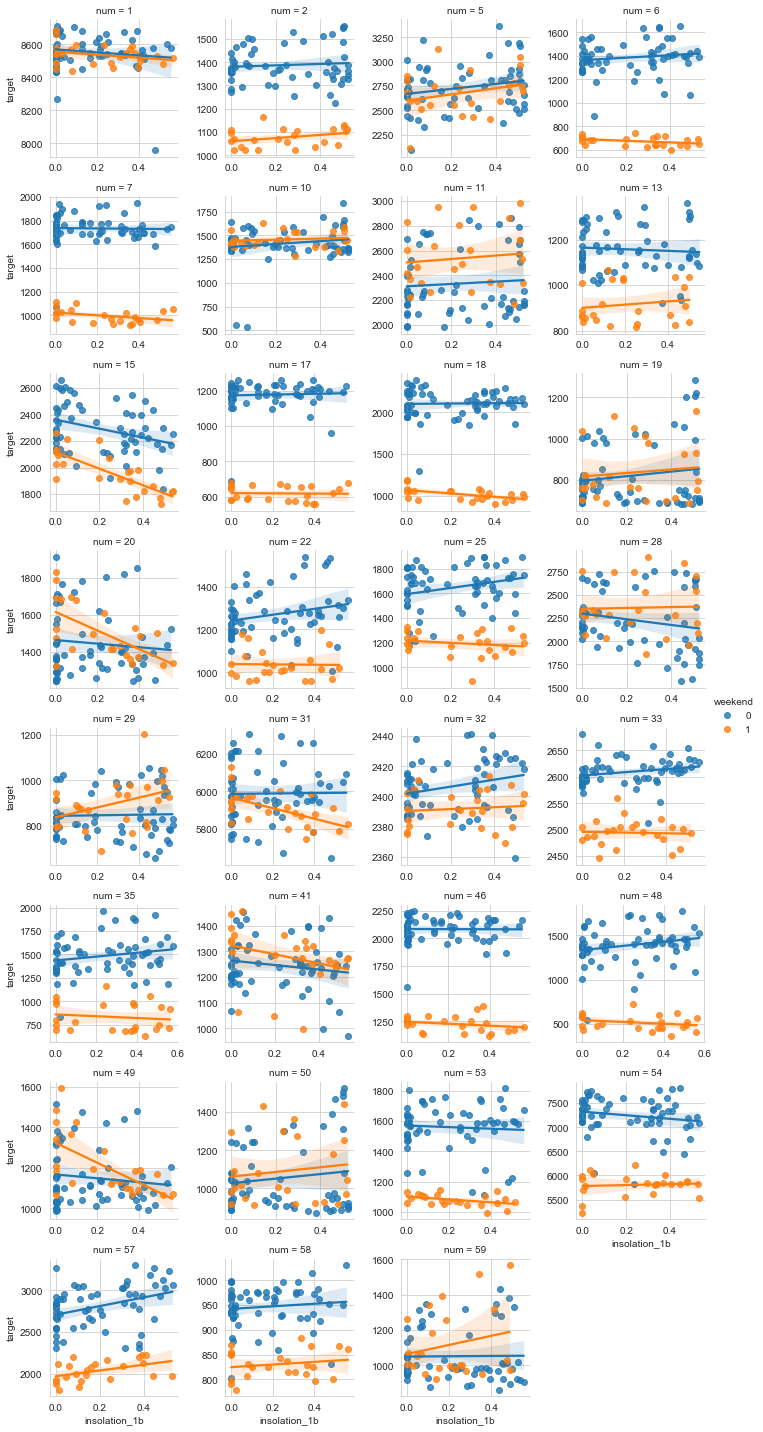

In [54]:
n_df = df.loc[df.solar_flag == 0.0]

n_df = n_df.groupby(['num','weekend','date'])['insolation','target'].mean().reset_index()
n_df['insolation_1b'] = n_df['insolation'].shift(1)

fig = plt.figure(figsize = (15, 25))
sns.lmplot(data = n_df, x = 'insolation_1b', y = 'target', hue = 'weekend', col = 'num', height = 2.5, aspect = 1,
          col_wrap = 4, sharey = False, sharex = False)

In [45]:
s_df.head(10)

num  weekend        date  insolation       target  insolation_1b  \
0    3        0  2020-06-01    0.491667  3246.295500            NaN   
1    3        0  2020-06-02    0.062500  3253.401000       0.491667   
2    3        0  2020-06-03    0.350000  3277.125000       0.062500   
3    3        0  2020-06-04    0.233333  3281.085000       0.350000   
4    3        0  2020-06-05    0.312500  3264.166853       0.233333   
5    3        0  2020-06-08    0.470833  3292.552000       0.312500   
6    3        0  2020-06-09    0.533333  3303.031500       0.470833   
7    3        0  2020-06-10    0.362500  3309.723000       0.533333   
8    3        0  2020-06-11    0.483333  3319.794000       0.362500   
9    3        0  2020-06-12    0.020833  3315.879000       0.483333   

   insolation_2b  insolation_3b  insolation_1c  insolation_2c  insolation_3c  
0            NaN            NaN            NaN            NaN            NaN  
1            NaN            NaN       0.554167            NaN            NaN  
2       0.491667            NaN       0.412500       0.904167            NaN  
3       0.062500       0.491667       0.583333       0.645833       1.137500  
4       0.350000       0.062500       0.545833       0.895833       0.958333  
5       0.233333       0.350000       0.783333       1.016667       1.366667  
6       0.312500       0.233333       1.004167       1.316667       1.550000  
7       0.470833       0.312500       0.895833       1.366667       1.679167  
8       0.533333       0.470833       0.845833       1.379167       1.850000  
9       0.362500       0.533333       0.504167       0.866667       1.400000

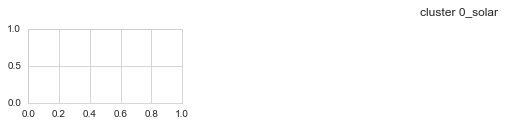

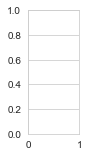

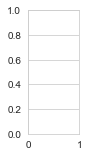

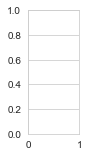

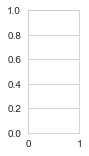

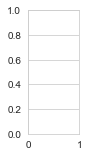

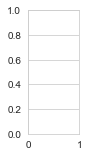

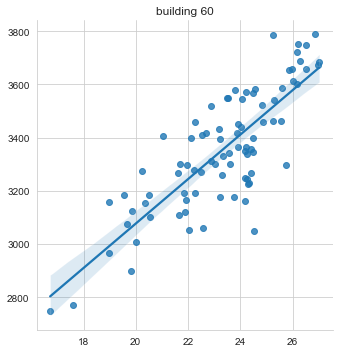

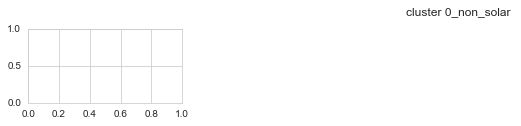

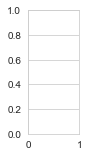

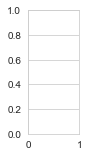

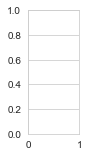

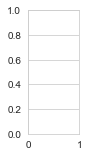

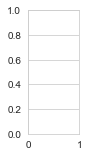

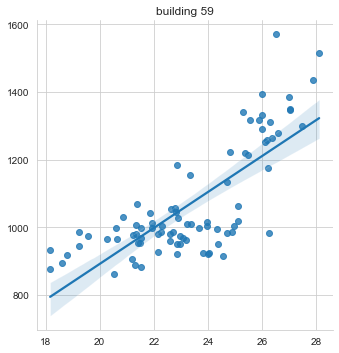

In [133]:
temp_1 = df[df.gmm == 2]
t1_sol = temp_1.loc[temp_1.solar_flag == 1.0]
t1_n_sol = temp_1.loc[temp_1.solar_flag == 0.0]

s_nums = np.unique(t1_sol.num)
n_nums = np.unique(t1_n_sol.num)

ss_nums = len(s_nums)
nn_nums = len(n_nums)

fig = plt.figure(figsize = (16, 3*((ss_nums)//5)))
plt.suptitle('cluster 0_solar ')
for i, num in enumerate(s_nums):
    temp_2 = t1_sol[t1_sol.num == num]
    temp_2 = temp_2.groupby(['num','date'])[['temp','target']].mean().reset_index()
    plt.subplot(ss_nums//5+1,5, i+1)
    sns.lmplot(data = temp_2, x='temp', y='target')
    plt.title(f'building {num}')
    plt.ylabel('')
    plt.xlabel('')
    plt.subplots_adjust(hspace = 0.5)

fig = plt.figure(figsize = (16, 3*((nn_nums)//5)))
plt.suptitle('cluster 0_non_solar ')
for i, num in enumerate(n_nums):
    temp_2 = t1_n_sol[t1_n_sol.num == num]
    temp_2 = temp_2.groupby(['num','date'])[['temp','target']].mean().reset_index()
    plt.subplot(nn_nums//5+1,5, i+1)
    sns.lmplot(data = temp_2, x='temp', y='target')
    plt.title(f'building {num}')
    plt.ylabel('')
    plt.xlabel('')
    plt.subplots_adjust(hspace = 0.5)


cluster별 → 태양광 발전기 보유 여부 별 → 온도별 전력 사용량의 변화치를 LinearRegression을 사용하여 확인

In [48]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

temp_1 = df[df.cluster == 1]
t1_sol = temp_1.loc[temp_1.solar_flag == 1.0]
sol_c = []
t1_n_sol = temp_1.loc[temp_1.solar_flag == 0.0]
sol_nc = []

for i, num in enumerate(np.unique(t1_sol.num)):
    temp_2 = t1_sol[t1_sol.num == num]
    temp_2 = temp_2.groupby(['num','date','weekend'])[['temp','target']].mean().reset_index()
    temp_2 = temp_2[temp_2['weekend'] == 1.0]
    x =  list(temp_2['temp'])
    x = np.reshape(x, (-1,1))
    y = list(temp_2['target'])
    y = np.reshape(y, (-1,1))
    model.fit(x, y)
    beta_0 = model.coef_[0]
    sol_c.append(beta_0)
    
for i, num in enumerate(np.unique(t1_n_sol.num)):
    temp_2 = t1_n_sol[t1_n_sol.num == num]
    temp_2 = temp_2.groupby(['num','date','weekend'])[['temp','target']].mean().reset_index()
    temp_2 = temp_2[temp_2['weekend'] == 1.0]
    x =  list(temp_2['temp'])
    x = np.reshape(x, (-1,1))
    y = list(temp_2['target'])
    y = np.reshape(y, (-1,1))
    model.fit(x, y)
    beta_0 = model.coef_[0]
    sol_nc.append(beta_0)
    
print("cluster1 태양광 발전기 O : ",np.unique(sol_c).mean())
print("cluster1 태양광 발전기 X : ",np.unique(sol_nc).mean())

print("-------------------------------------------------------------------------------------------")

temp_1 = df[df.cluster == 2]
t1_sol = temp_1.loc[temp_1.solar_flag == 1.0]
sol_c = []
t1_n_sol = temp_1.loc[temp_1.solar_flag == 0.0]
sol_nc = []

for i, num in enumerate(np.unique(t1_sol.num)):
    temp_2 = t1_sol[t1_sol.num == num]
    temp_2 = temp_2.groupby(['num','date','weekend'])[['temp','target']].mean().reset_index()
    temp_2 = temp_2[temp_2['weekend'] == 1.0]
    x =  list(temp_2['temp'])
    x = np.reshape(x, (-1,1))
    y = list(temp_2['target'])
    y = np.reshape(y, (-1,1))
    model.fit(x, y)
    beta_0 = model.coef_[0]
    sol_c.append(beta_0)
    
for i, num in enumerate(np.unique(t1_n_sol.num)):
    temp_2 = t1_n_sol[t1_n_sol.num == num]
    temp_2 = temp_2.groupby(['num','date','weekend'])[['temp','target']].mean().reset_index()
    temp_2 = temp_2[temp_2['weekend'] == 1.0]
    x =  list(temp_2['temp'])
    x = np.reshape(x, (-1,1))
    y = list(temp_2['target'])
    y = np.reshape(y, (-1,1))
    model.fit(x, y)
    beta_0 = model.coef_[0]
    sol_nc.append(beta_0)
    
print("cluster2 태양광 발전기 O : ",np.unique(sol_c).mean())
print("cluster2 태양광 발전기 X : ",np.unique(sol_nc).mean())

print("-------------------------------------------------------------------------------------------")

temp_1 = df[df.cluster == 3]
t1_sol = temp_1.loc[temp_1.solar_flag == 1.0]
sol_c = []
t1_n_sol = temp_1.loc[temp_1.solar_flag == 0.0]
sol_nc = []

for i, num in enumerate(np.unique(t1_sol.num)):
    temp_2 = t1_sol[t1_sol.num == num]
    temp_2 = temp_2.groupby(['num','date','weekend'])[['temp','target']].mean().reset_index()
    temp_2 = temp_2[temp_2['weekend'] == 1.0]
    x =  list(temp_2['temp'])
    x = np.reshape(x, (-1,1))
    y = list(temp_2['target'])
    y = np.reshape(y, (-1,1))
    model.fit(x, y)
    beta_0 = model.coef_[0]
    sol_c.append(beta_0)
    
for i, num in enumerate(np.unique(t1_n_sol.num)):
    temp_2 = t1_n_sol[t1_n_sol.num == num]
    temp_2 = temp_2.groupby(['num','date','weekend'])[['temp','target']].mean().reset_index()
    temp_2 = temp_2[temp_2['weekend'] == 1.0]
    x =  list(temp_2['temp'])
    x = np.reshape(x, (-1,1))
    y = list(temp_2['target'])
    y = np.reshape(y, (-1,1))
    model.fit(x, y)
    beta_0 = model.coef_[0]
    sol_nc.append(beta_0)
    
print("cluster3 태양광 발전기 O : ",np.unique(sol_c).mean())
print("cluster3 태양광 발전기 X : ",np.unique(sol_nc).mean())

print("-------------------------------------------------------------------------------------------")

temp_1 = df[df.cluster == 4]
t1_sol = temp_1.loc[temp_1.solar_flag == 1.0]
sol_c = []
t1_n_sol = temp_1.loc[temp_1.solar_flag == 0.0]
sol_nc = []

for i, num in enumerate(np.unique(t1_sol.num)):
    temp_2 = t1_sol[t1_sol.num == num]
    temp_2 = temp_2.groupby(['num','date','weekend'])[['temp','target']].mean().reset_index()
    temp_2 = temp_2[temp_2['weekend'] == 1.0]
    x =  list(temp_2['temp'])
    x = np.reshape(x, (-1,1))
    y = list(temp_2['target'])
    y = np.reshape(y, (-1,1))
    model.fit(x, y)
    beta_0 = model.coef_[0]
    sol_c.append(beta_0)
    
for i, num in enumerate(np.unique(t1_n_sol.num)):
    temp_2 = t1_n_sol[t1_n_sol.num == num]
    temp_2 = temp_2.groupby(['num','date','weekend'])[['temp','target']].mean().reset_index()
    temp_2 = temp_2[temp_2['weekend'] == 1.0]
    x =  list(temp_2['temp'])
    x = np.reshape(x, (-1,1))
    y = list(temp_2['target'])
    y = np.reshape(y, (-1,1))
    model.fit(x, y)
    beta_0 = model.coef_[0]
    sol_nc.append(beta_0)
    
print("cluster4 태양광 발전기 O : ",np.unique(sol_c).mean())
print("cluster4 태양광 발전기 X : ",np.unique(sol_nc).mean())

print("-------------------------------------------------------------------------------------------")

temp_1 = df[df.cluster == 5]
t1_sol = temp_1.loc[temp_1.solar_flag == 1.0]
sol_c = []
t1_n_sol = temp_1.loc[temp_1.solar_flag == 0.0]
sol_nc = []

for i, num in enumerate(np.unique(t1_sol.num)):
    temp_2 = t1_sol[t1_sol.num == num]
    temp_2 = temp_2.groupby(['num','date','weekend'])[['temp','target']].mean().reset_index()
    temp_2 = temp_2[temp_2['weekend'] == 1.0]
    x =  list(temp_2['temp'])
    x = np.reshape(x, (-1,1))
    y = list(temp_2['target'])
    y = np.reshape(y, (-1,1))
    model.fit(x, y)
    beta_0 = model.coef_[0]
    sol_c.append(beta_0)
    
for i, num in enumerate(np.unique(t1_n_sol.num)):
    temp_2 = t1_n_sol[t1_n_sol.num == num]
    temp_2 = temp_2.groupby(['num','date','weekend'])[['temp','target']].mean().reset_index()
    temp_2 = temp_2[temp_2['weekend'] == 1.0]
    x =  list(temp_2['temp'])
    x = np.reshape(x, (-1,1))
    y = list(temp_2['target'])
    y = np.reshape(y, (-1,1))
    model.fit(x, y)
    beta_0 = model.coef_[0]
    sol_nc.append(beta_0)
    
print("cluster5 태양광 발전기 O : ",np.unique(sol_c).mean())
print("cluster5 태양광 발전기 X : ",np.unique(sol_nc).mean())
    


cluster1 태양광 발전기 O :  42.61309899408808
cluster1 태양광 발전기 X :  30.607246893049126
-------------------------------------------------------------------------------------------
cluster2 태양광 발전기 O :  68.68205976817
cluster2 태양광 발전기 X :  36.2903916451154
-------------------------------------------------------------------------------------------
cluster3 태양광 발전기 O :  83.50898623413322
cluster3 태양광 발전기 X :  61.36362176850932
-------------------------------------------------------------------------------------------
cluster4 태양광 발전기 O :  73.52267963937108
cluster4 태양광 발전기 X :  49.02558533820715
-------------------------------------------------------------------------------------------
cluster5 태양광 발전기 O :  82.77476973917004
cluster5 태양광 발전기 X :  14.050554207668979


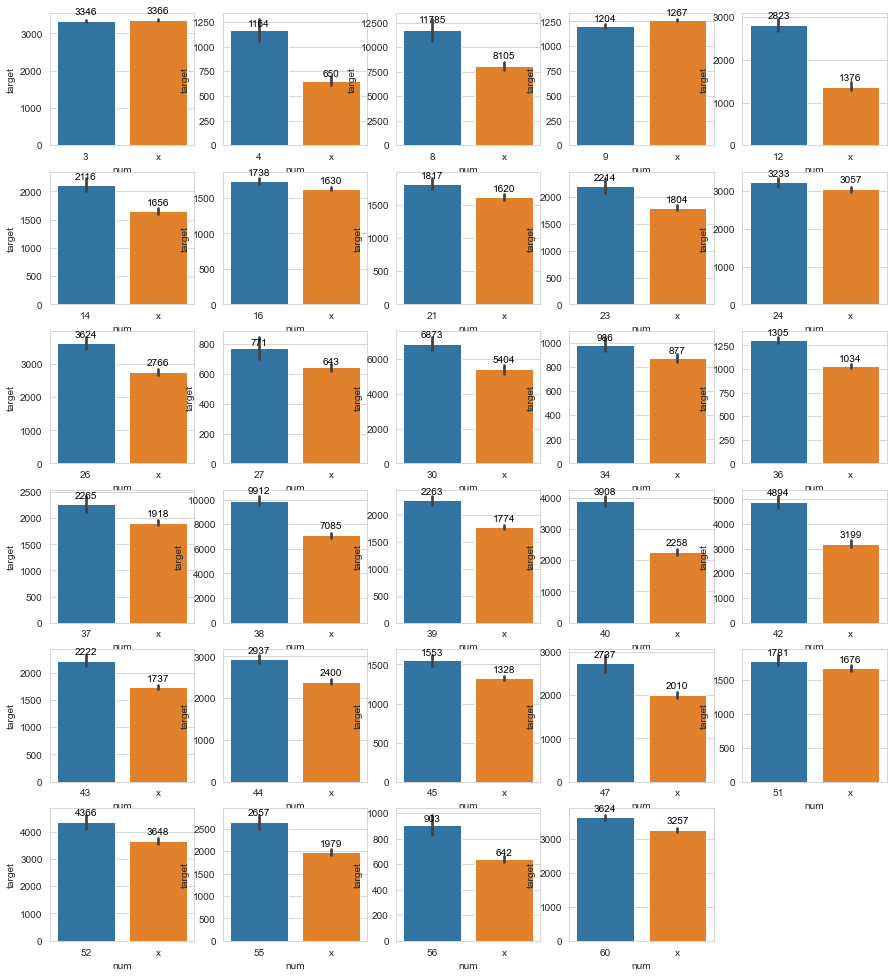

In [164]:
# solar_df = 태양광을 가지고 있는 건물
list_solar = np.unique(solar_df['num'])
a = 1


plt.figure(figsize=(15,20))
for i in list_solar:
    inso = solar_df[solar_df['num'] == i]
    inso_r = inso[inso['insolation'] >= 0.8]
    inso_r = inso_r.groupby(['num','date'])[['insolation','target']].mean().reset_index()
    inso_s = inso[inso['insolation'] < 0.8]
    inso_s = inso_s.groupby(['num','date'])[['insolation','target']].mean().reset_index()
    inso_s['num'] = 'x'
    inso_st = pd.concat([inso_r,inso_s])
    plt.subplot(7,5,a)
    a += 1
    ax = sns.barplot(data=inso_st, x='num', y = 'target')
    for p in ax.patches: 
        ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width()/2., p.get_height() - 30), 
           ha='center', va='center', fontsize=10, color='black', xytext=(0, 10), 
           textcoords='offset points') 



## 비전력 냉방기

<Figure size 432x288 with 0 Axes>

<Figure size 1080x1800 with 0 Axes>

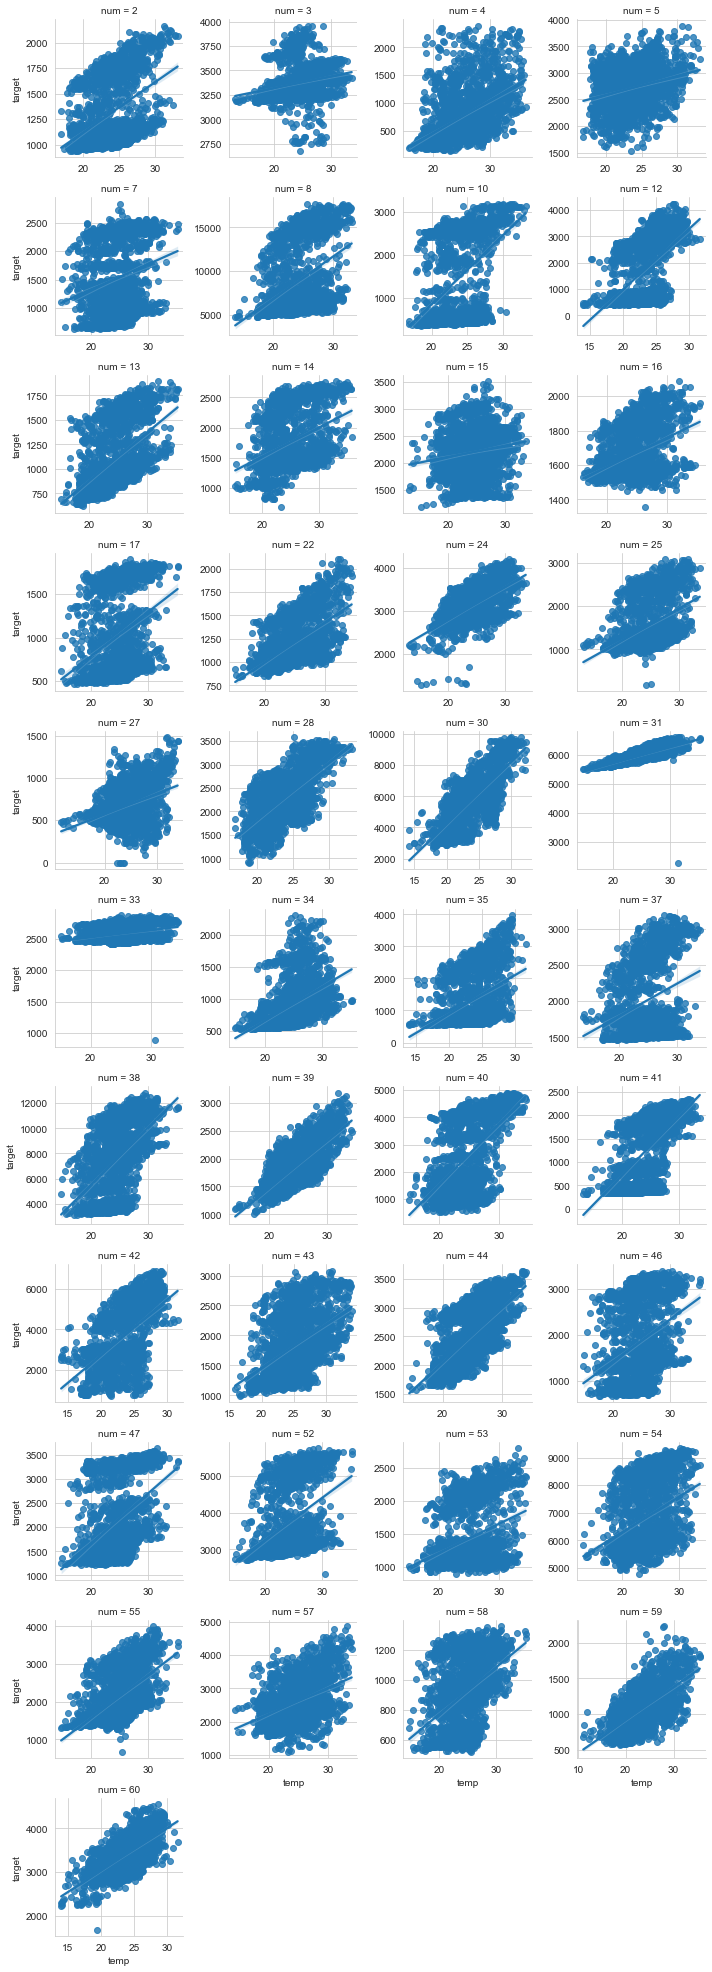

In [145]:
nelec = df[df['nelec_cool_flag'] == 1.0]
n_nelec = df[df['nelec_cool_flag'] == 0.0]

#fig = plt.figure(figsize = (10,10))
plt.suptitle('비전력냉방기 보유')
fig = plt.figure(figsize = (15, 25))
sns.lmplot(data = nelec, x = 'temp', y = 'target',col = 'num', height = 2.5, aspect = 1,
          col_wrap = 4, sharey = False, sharex = False)


<Figure size 432x288 with 0 Axes>

<Figure size 1080x1800 with 0 Axes>

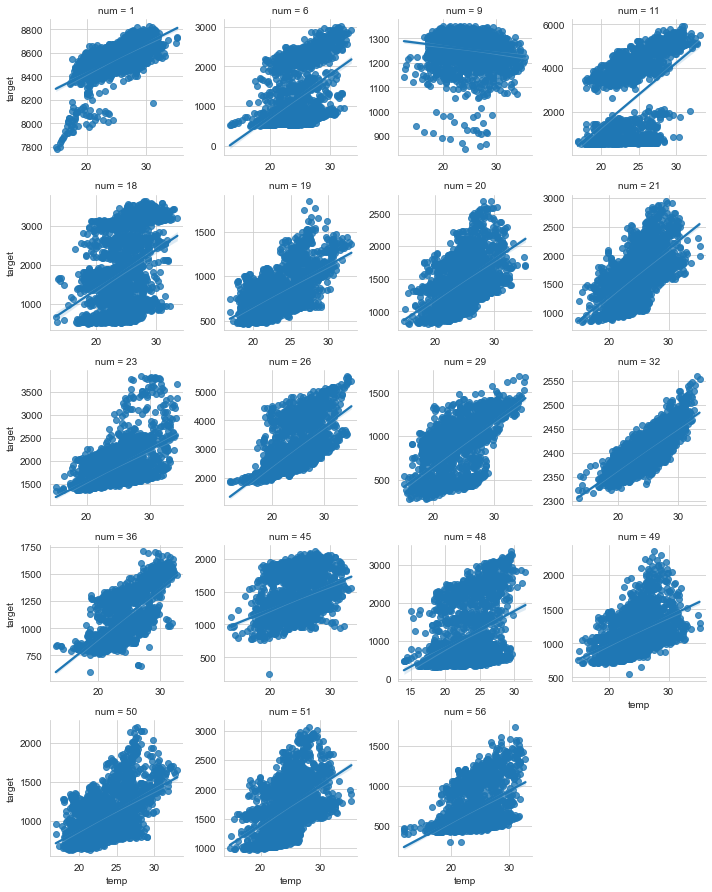

In [147]:
n_nelec = df[df['nelec_cool_flag'] == 0.0]

#fig = plt.figure(figsize = (10,10))
plt.suptitle('비전력냉방기 보유 X')
fig = plt.figure(figsize = (15, 25))
sns.lmplot(data = n_nelec, x = 'temp', y = 'target',col = 'num', height = 2.5, aspect = 1,
          col_wrap = 4, sharey = False, sharex = False)

In [82]:
c_n_1 = df[df.cluster == 1]
nelec = c_n_1[c_n_1['nelec_cool_flag'] == 1.0]
n_nelec = c_n_1[c_n_1['nelec_cool_flag'] == 0.0]

# 비전기 시설 소유하지 않음
n_dt = n_nelec.groupby(['num','date'])['temp','humidity','windspeed','insolation','precipitation','target'].mean().reset_index()
corrs_1_n = []
for num in np.unique(n_nelec['num']):
    corr = []
    corr.append(num)
    for feat in ['temp','humidity','windspeed','insolation','precipitation']:
        corr.append(spearmanr(n_dt.loc[n_dt.num == num, feat], n_dt.loc[n_dt.num == num, 'target']).correlation)
    corrs_1_n.append(corr)
    
# 비전기 시설 소유
nn_dt = nelec.groupby(['num','date'])['temp','humidity','windspeed','insolation','precipitation','target'].mean().reset_index()
corrs_1_y = []
for num in np.unique(nelec['num']):
    corr = []
    corr.append(num)
    for feat in ['temp','humidity','windspeed','insolation','precipitation']:
        corr.append(spearmanr(nn_dt.loc[nn_dt.num == num, feat], nn_dt.loc[nn_dt.num == num, 'target']).correlation)
    corrs_1_y.append(corr)
    
"-------------------------------------------------------------------------------------------"

c_n_1 = df[df.cluster == 2]
nelec = c_n_1[c_n_1['nelec_cool_flag'] == 1.0]
n_nelec = c_n_1[c_n_1['nelec_cool_flag'] == 0.0]

# 비전기 시설 소유하지 않음
n_dt = n_nelec.groupby(['num','date'])['temp','humidity','windspeed','insolation','precipitation','target'].mean().reset_index()
corrs_2_n = []
for num in np.unique(n_nelec['num']):
    corr = []
    corr.append(num)
    for feat in ['temp','humidity','windspeed','insolation','precipitation']:
        corr.append(spearmanr(n_dt.loc[n_dt.num == num, feat], n_dt.loc[n_dt.num == num, 'target']).correlation)
    corrs_2_n.append(corr)
    
# 비전기 시설 소유
nn_dt = nelec.groupby(['num','date'])['temp','humidity','windspeed','insolation','precipitation','target'].mean().reset_index()
corrs_2_y = []
for num in np.unique(nelec['num']):
    corr = []
    corr.append(num)
    for feat in ['temp','humidity','windspeed','insolation','precipitation']:
        corr.append(spearmanr(nn_dt.loc[nn_dt.num == num, feat], nn_dt.loc[nn_dt.num == num, 'target']).correlation)
    corrs_2_y.append(corr)

"-------------------------------------------------------------------------------------------"

c_n_1 = df[df.cluster == 3]
nelec = c_n_1[c_n_1['nelec_cool_flag'] == 1.0]
n_nelec = c_n_1[c_n_1['nelec_cool_flag'] == 0.0]

# 비전기 시설 소유하지 않음
n_dt = n_nelec.groupby(['num','date'])['temp','humidity','windspeed','insolation','precipitation','target'].mean().reset_index()
corrs_3_n = []
for num in np.unique(n_nelec['num']):
    corr = []
    corr.append(num)
    for feat in ['temp','humidity','windspeed','insolation','precipitation']:
        corr.append(spearmanr(n_dt.loc[n_dt.num == num, feat], n_dt.loc[n_dt.num == num, 'target']).correlation)
    corrs_3_n.append(corr)
    
    
"-------------------------------------------------------------------------------------------"

c_n_1 = df[df.cluster == 4]
nelec = c_n_1[c_n_1['nelec_cool_flag'] == 1.0]
n_nelec = c_n_1[c_n_1['nelec_cool_flag'] == 0.0]

# 비전기 시설 소유하지 않음
n_dt = n_nelec.groupby(['num','date'])['temp','humidity','windspeed','insolation','precipitation','target'].mean().reset_index()
corrs_4_n = []
for num in np.unique(n_nelec['num']):
    corr = []
    corr.append(num)
    for feat in ['temp','humidity','windspeed','insolation','precipitation']:
        corr.append(spearmanr(n_dt.loc[n_dt.num == num, feat], n_dt.loc[n_dt.num == num, 'target']).correlation)
    corrs_4_n.append(corr)
    
# 비전기 시설 소유
nn_dt = nelec.groupby(['num','date'])['temp','humidity','windspeed','insolation','precipitation','target'].mean().reset_index()
corrs_4_y = []
for num in np.unique(nelec['num']):
    corr = []
    corr.append(num)
    for feat in ['temp','humidity','windspeed','insolation','precipitation']:
        corr.append(spearmanr(nn_dt.loc[nn_dt.num == num, feat], nn_dt.loc[nn_dt.num == num, 'target']).correlation)
    corrs_4_y.append(corr)

"-------------------------------------------------------------------------------------------"
    
c_n_1 = df[df.cluster == 5]
nelec = c_n_1[c_n_1['nelec_cool_flag'] == 1.0]
n_nelec = c_n_1[c_n_1['nelec_cool_flag'] == 0.0]

# 비전기 시설 소유하지 않음
n_dt = n_nelec.groupby(['num','date'])['temp','humidity','windspeed','insolation','precipitation','target'].mean().reset_index()
corrs_5_n = []
for num in np.unique(n_nelec['num']):
    corr = []
    corr.append(num)
    for feat in ['temp','humidity','windspeed','insolation','precipitation']:
        corr.append(spearmanr(n_dt.loc[n_dt.num == num, feat], n_dt.loc[n_dt.num == num, 'target']).correlation)
    corrs_5_n.append(corr)
    
# 비전기 시설 소유
nn_dt = nelec.groupby(['num','date'])['temp','humidity','windspeed','insolation','precipitation','target'].mean().reset_index()
corrs_5_y = []
for num in np.unique(nelec['num']):
    corr = []
    corr.append(num)
    for feat in ['temp','humidity','windspeed','insolation','precipitation']:
        corr.append(spearmanr(nn_dt.loc[nn_dt.num == num, feat], nn_dt.loc[nn_dt.num == num, 'target']).correlation)
    corrs_5_y.append(corr)

corrs_1 = [corrs_1_n, corrs_1_y]
corrs_2 = [corrs_2_n, corrs_2_y]
corrs_3 = [corrs_3_n]
corrs_4 = [corrs_4_n, corrs_4_y]
corrs_5 = [corrs_5_n, corrs_5_y]

C:\Users\psw\AppData\Local\Temp/ipykernel_6660/1135406314.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  n_dt = n_nelec.groupby(['num','date'])['temp','humidity','windspeed','insolation','precipitation','target'].mean().reset_index()
C:\Users\psw\AppData\Local\Temp/ipykernel_6660/1135406314.py:16: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  nn_dt = nelec.groupby(['num','date'])['temp','humidity','windspeed','insolation','precipitation','target'].mean().reset_index()
C:\Users\psw\AppData\Local\Temp/ipykernel_6660/1135406314.py:32: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  n_dt = n_nelec.groupby(['num','date'])['temp','humidity','windspeed','insolation','precipitation','target'].mean().reset_index()
C:\Users\psw\AppData\Local\Temp/ipykern

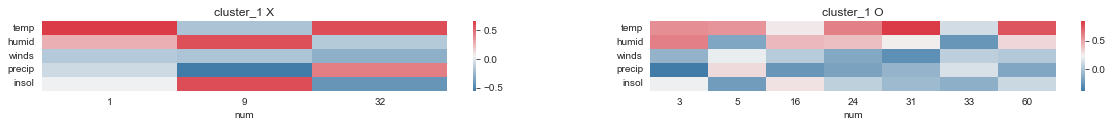

In [84]:
a='X'
fig = plt.figure(figsize = (20, 10))
for i, corrs in enumerate(corrs_1):
    
    corr_df = pd.DataFrame(np.array(corrs), columns = ['num','temp','humid','winds','precip','insol'])
    corr_df['num'] = corr_df['num'].astype(int)
    corr_df = corr_df.set_index('num')

    plt.subplot(5,2,i+1)
    sns.heatmap(corr_df.transpose(), cmap=sns.diverging_palette(240,10,as_cmap=True))
    plt.subplots_adjust(hspace = 0.7)
    plt.title('cluster_1 '+a)
    a='O'

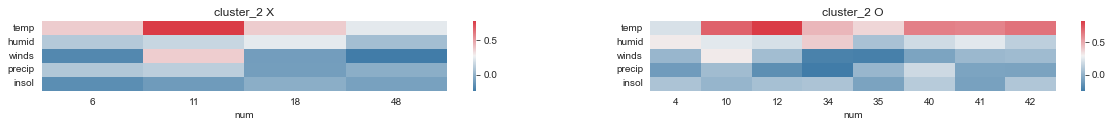

In [85]:
a='X'
fig = plt.figure(figsize = (20, 10))
for i, corrs in enumerate(corrs_2):
    
    corr_df = pd.DataFrame(np.array(corrs), columns = ['num','temp','humid','winds','precip','insol'])
    corr_df['num'] = corr_df['num'].astype(int)
    corr_df = corr_df.set_index('num')

    plt.subplot(5,2,i+1)
    sns.heatmap(corr_df.transpose(), cmap=sns.diverging_palette(240,10,as_cmap=True))
    plt.subplots_adjust(hspace = 0.7)
    plt.title('cluster_2 '+a)
    a='O'

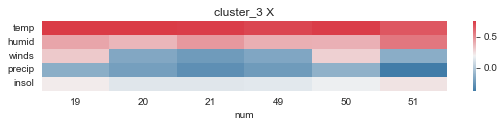

In [86]:
a='X'
fig = plt.figure(figsize = (20, 10))
for i, corrs in enumerate(corrs_3):
    
    corr_df = pd.DataFrame(np.array(corrs), columns = ['num','temp','humid','winds','precip','insol'])
    corr_df['num'] = corr_df['num'].astype(int)
    corr_df = corr_df.set_index('num')

    plt.subplot(5,2,i+1)
    sns.heatmap(corr_df.transpose(), cmap=sns.diverging_palette(240,10,as_cmap=True))
    plt.subplots_adjust(hspace = 0.7)
    plt.title('cluster_3 '+a)
    a='O'

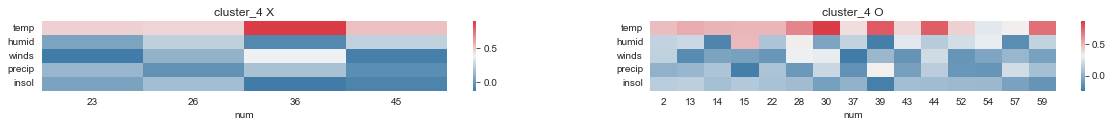

In [87]:
a='X'
fig = plt.figure(figsize = (20, 10))
for i, corrs in enumerate(corrs_4):
    
    corr_df = pd.DataFrame(np.array(corrs), columns = ['num','temp','humid','winds','precip','insol'])
    corr_df['num'] = corr_df['num'].astype(int)
    corr_df = corr_df.set_index('num')

    plt.subplot(5,2,i+1)
    sns.heatmap(corr_df.transpose(), cmap=sns.diverging_palette(240,10,as_cmap=True))
    plt.subplots_adjust(hspace = 0.7)
    plt.title('cluster_4 '+a)
    a='O'

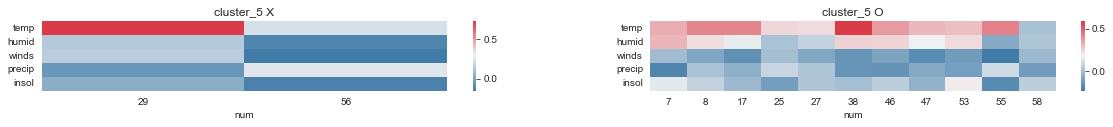

In [88]:
a='X'
fig = plt.figure(figsize = (20, 10))
for i, corrs in enumerate(corrs_5):
    
    corr_df = pd.DataFrame(np.array(corrs), columns = ['num','temp','humid','winds','precip','insol'])
    corr_df['num'] = corr_df['num'].astype(int)
    corr_df = corr_df.set_index('num')

    plt.subplot(5,2,i+1)
    sns.heatmap(corr_df.transpose(), cmap=sns.diverging_palette(240,10,as_cmap=True))
    plt.subplots_adjust(hspace = 0.7)
    plt.title('cluster_5 '+a)
    a='O'

In [166]:
from scipy import stats


#a = stats.spearmanr(n_dt['temp'],n_dt['target'])
a = stats.pearsonr(n_dt['temp'],n_dt['target'])

#b = stats.spearmanr(nn_dt['temp'],nn_dt['target'])
b = stats.pearsonr(nn_dt['temp'],nn_dt['target'])

print("비전기 시설 보유 : ", a)
print("비전기 시설 미보유 : ", b)


비전기 시설 보유 :  (0.11572991742845214, 3.1175431096437474e-06)
비전기 시설 미보유 :  (0.05471809051027212, 0.0012314928455320776)


In [165]:
n_dt

num        date       temp   humidity  windspeed  insolation  \
0       1  2020-06-01  19.841667  65.208333   3.375000    0.479167   
1       1  2020-06-02  17.900000  69.041667   2.112500    0.008333   
2       1  2020-06-03  21.841667  73.416667   2.375000    0.395833   
3       1  2020-06-04  21.908333  79.875000   2.679167    0.195833   
4       1  2020-06-05  22.862500  71.458333   1.962500    0.366667   
...   ...         ...        ...        ...        ...         ...   
1610   56  2020-08-20  26.545833  82.625000   0.691667    0.383333   
1611   56  2020-08-21  26.354167  86.208333   0.641667    0.358333   
1612   56  2020-08-22  25.058333  92.750000   0.983333    0.016667   
1613   56  2020-08-23  24.895833  85.416667   0.783333    0.316667   
1614   56  2020-08-24  26.033333  83.250000   0.929167    0.454167   

      precipitation     target  
0          0.050000  8049.7800  
1          0.079167  7958.1690  
2          0.004167  8269.6140  
3          0.008333  8459.7480  
4          0.000000  8611.4610  
...             ...        ...  
1610       0.000000   938.4660  
1611       0.000000   838.2555  
1612       0.275000   561.0195  
1613       0.000000   561.1950  
1614       0.000000   889.7580  

[1615 rows x 8 columns]

In [91]:
temp_1 = df[df.cluster == 1]
t1_nel = temp_1.loc[temp_1['nelec_cool_flag'] == 1.0]
sol_c = []
t1_n_nel = temp_1.loc[temp_1['nelec_cool_flag'] == 0.0]
sol_nc = []

temp_2 = t1_nel.groupby(['date'])[['temp','target']].mean().reset_index()
a = spearmanr(temp_2['temp'],temp_2['target'])
print("cluster1 / 비전력냉방기 보유", a)

temp_2 = t1_n_nel.groupby(['date'])[['temp','target']].mean().reset_index()
a = spearmanr(temp_2['temp'],temp_2['target'])
print("cluster1 / 비전력냉방기 미보유", a)
print("-------------------------------------")

"-------------------------------------------------------------------------------------------------------"

temp_1 = df[df.cluster == 2]
t1_nel = temp_1.loc[temp_1['nelec_cool_flag'] == 1.0]
sol_c = []
t1_n_nel = temp_1.loc[temp_1['nelec_cool_flag'] == 0.0]
sol_nc = []

temp_2 = t1_nel.groupby(['date'])[['temp','target']].mean().reset_index()
a = spearmanr(temp_2['temp'],temp_2['target'])
print("cluster2 / 비전력냉방기 보유 : " , a)

temp_2 = t1_n_nel.groupby(['date'])[['temp','target']].mean().reset_index()
a = spearmanr(temp_2['temp'],temp_2['target'])
print("cluster2 / 비전력냉방기 미보유 : ", a)
print("-------------------------------------")

"-------------------------------------------------------------------------------------------------------"

temp_1 = df[df.cluster == 3]
t1_nel = temp_1.loc[temp_1['nelec_cool_flag'] == 1.0]
sol_c = []
t1_n_nel = temp_1.loc[temp_1['nelec_cool_flag'] == 0.0]
sol_nc = []

temp_2 = t1_nel.groupby(['date'])[['temp','target']].mean().reset_index()
a = spearmanr(temp_2['temp'],temp_2['target'])
print("cluster3 / 비전력냉방기 보유 : " , a)

temp_2 = t1_n_nel.groupby(['date'])[['temp','target']].mean().reset_index()
a = spearmanr(temp_2['temp'],temp_2['target'])
print("cluster3 / 비전력냉방기 미보유 : ", a)
print("-------------------------------------")

"-------------------------------------------------------------------------------------------------------"

temp_1 = df[df.cluster == 4]
t1_nel = temp_1.loc[temp_1['nelec_cool_flag'] == 1.0]
sol_c = []
t1_n_nel = temp_1.loc[temp_1['nelec_cool_flag'] == 0.0]
sol_nc = []

temp_2 = t1_nel.groupby(['date'])[['temp','target']].mean().reset_index()
a = spearmanr(temp_2['temp'],temp_2['target'])
print("cluster4 / 비전력냉방기 보유 : " , a)

temp_2 = t1_n_nel.groupby(['date'])[['temp','target']].mean().reset_index()
a = spearmanr(temp_2['temp'],temp_2['target'])
print("cluster4 / 비전력냉방기 미보유 : ", a)
print("-------------------------------------")

"-------------------------------------------------------------------------------------------------------"

temp_1 = df[df.cluster == 5]
t1_nel = temp_1.loc[temp_1['nelec_cool_flag'] == 1.0]
sol_c = []
t1_n_nel = temp_1.loc[temp_1['nelec_cool_flag'] == 0.0]
sol_nc = []

temp_2 = t1_nel.groupby(['date'])[['temp','target']].mean().reset_index()
a = spearmanr(temp_2['temp'],temp_2['target'])
print("cluster5 / 비전력냉방기 보유 : " , a)

temp_2 = t1_n_nel.groupby(['date'])[['temp','target']].mean().reset_index()
a = spearmanr(temp_2['temp'],temp_2['target'])
print("cluster5 / 비전력냉방기 미보유 : ", a)
print("-------------------------------------")


cluster1 / 비전력냉방기 보유 SpearmanrResult(correlation=0.7630838381864374, pvalue=2.093801510638075e-17)
cluster1 / 비전력냉방기 미보유 SpearmanrResult(correlation=0.7371151901357769, pvalue=8.760272365592897e-16)
-------------------------------------
cluster2 / 비전력냉방기 보유 :  SpearmanrResult(correlation=0.6943912448700411, pvalue=1.708479771484329e-13)
cluster2 / 비전력냉방기 미보유 :  SpearmanrResult(correlation=0.4417041235098691, pvalue=2.318296733345491e-05)
-------------------------------------
cluster3 / 비전력냉방기 보유 :  SpearmanrResult(correlation=nan, pvalue=nan)
cluster3 / 비전력냉방기 미보유 :  SpearmanrResult(correlation=0.8319368376923489, pvalue=6.118621474660558e-23)
-------------------------------------
cluster4 / 비전력냉방기 보유 :  SpearmanrResult(correlation=0.5814735196404144, pvalue=5.365870206367706e-09)
cluster4 / 비전력냉방기 미보유 :  SpearmanrResult(correlation=0.5605432870822749, pvalue=2.4205891454956123e-08)
-------------------------------------
cluster5 / 비전력냉방기 보유 :  SpearmanrResult(correlation=0.436427594293

In [96]:
temp_1 = df[df.cluster == 1]
t1_nel = temp_1.loc[temp_1['nelec_cool_flag'] == 1.0]
sol_c = []
t1_n_nel = temp_1.loc[temp_1['nelec_cool_flag'] == 0.0]
sol_nc = []

temp_2 = t1_nel.groupby(['date'])[['humidity','target']].mean().reset_index()
a = spearmanr(temp_2['humidity'],temp_2['target'])
print("cluster1 / 비전력냉방기 보유 : " , a)

temp_2 = t1_n_nel.groupby(['date'])[['humidity','target']].mean().reset_index()
a = spearmanr(temp_2['humidity'],temp_2['target'])
print("cluster1 / 비전력냉방기 미보유 : ", a)
print("-------------------------------------")

"-------------------------------------------------------------------------------------------------------"

temp_1 = df[df.cluster == 2]
t1_nel = temp_1.loc[temp_1['nelec_cool_flag'] == 1.0]
sol_c = []
t1_n_nel = temp_1.loc[temp_1['nelec_cool_flag'] == 0.0]
sol_nc = []

temp_2 = t1_nel.groupby(['date'])[['humidity','target']].mean().reset_index()
a = spearmanr(temp_2['humidity'],temp_2['target'])
print("cluster2 / 비전력냉방기 보유 : " , a)

temp_2 = t1_n_nel.groupby(['date'])[['humidity','target']].mean().reset_index()
a = spearmanr(temp_2['humidity'],temp_2['target'])
print("cluster2 / 비전력냉방기 미보유 : ", a)
print("-------------------------------------")

"-------------------------------------------------------------------------------------------------------"

temp_1 = df[df.cluster == 3]
t1_nel = temp_1.loc[temp_1['nelec_cool_flag'] == 1.0]
sol_c = []
t1_n_nel = temp_1.loc[temp_1['nelec_cool_flag'] == 0.0]
sol_nc = []

temp_2 = t1_nel.groupby(['date'])[['humidity','target']].mean().reset_index()
a = spearmanr(temp_2['humidity'],temp_2['target'])
print("cluster3 / 비전력냉방기 보유 : " , a)

temp_2 = t1_n_nel.groupby(['date'])[['humidity','target']].mean().reset_index()
a = spearmanr(temp_2['humidity'],temp_2['target'])
print("cluster3 / 비전력냉방기 미보유 : ", a)
print("-------------------------------------")

"-------------------------------------------------------------------------------------------------------"

temp_1 = df[df.cluster == 4]
t1_nel = temp_1.loc[temp_1['nelec_cool_flag'] == 1.0]
sol_c = []
t1_n_nel = temp_1.loc[temp_1['nelec_cool_flag'] == 0.0]
sol_nc = []

temp_2 = t1_nel.groupby(['date'])[['humidity','target']].mean().reset_index()
a = spearmanr(temp_2['humidity'],temp_2['target'])
print("cluster4 / 비전력냉방기 보유 : " , a)

temp_2 = t1_n_nel.groupby(['date'])[['humidity','target']].mean().reset_index()
a = spearmanr(temp_2['humidity'],temp_2['target'])
print("cluster4 / 비전력냉방기 미보유 : ", a)
print("-------------------------------------")

"-------------------------------------------------------------------------------------------------------"

temp_1 = df[df.cluster == 5]
t1_nel = temp_1.loc[temp_1['nelec_cool_flag'] == 1.0]
sol_c = []
t1_n_nel = temp_1.loc[temp_1['nelec_cool_flag'] == 0.0]
sol_nc = []

temp_2 = t1_nel.groupby(['date'])[['humidity','target']].mean().reset_index()
a = spearmanr(temp_2['humidity'],temp_2['target'])
print("cluster5 / 비전력냉방기 보유 : " , a)

temp_2 = t1_n_nel.groupby(['date'])[['humidity','target']].mean().reset_index()
a = spearmanr(temp_2['humidity'],temp_2['target'])
print("cluster5 / 비전력냉방기 미보유 : ", a)

cluster1 / 비전력냉방기 보유 :  SpearmanrResult(correlation=0.4370474599335081, pvalue=2.88874366159398e-05)
cluster1 / 비전력냉방기 미보유 :  SpearmanrResult(correlation=0.2987551056874142, pvalue=0.00548067044167494)
-------------------------------------
cluster2 / 비전력냉방기 보유 :  SpearmanrResult(correlation=0.3029704905217901, pvalue=0.004825494500920494)
cluster2 / 비전력냉방기 미보유 :  SpearmanrResult(correlation=0.2602221038828394, pvalue=0.016163605584652425)
-------------------------------------
cluster3 / 비전력냉방기 보유 :  SpearmanrResult(correlation=nan, pvalue=nan)
cluster3 / 비전력냉방기 미보유 :  SpearmanrResult(correlation=0.506336782677902, pvalue=7.656755101990494e-07)
-------------------------------------
cluster4 / 비전력냉방기 보유 :  SpearmanrResult(correlation=0.3677679086349956, pvalue=0.0005349017902696682)
cluster4 / 비전력냉방기 미보유 :  SpearmanrResult(correlation=0.28653507914793824, pvalue=0.007846579171434486)
-------------------------------------
cluster5 / 비전력냉방기 보유 :  SpearmanrResult(correlation=0.2269102990033

In [105]:
def env_temp(T, RH, V, P, S):
    # c1~c6는 자역의 기후조건에 따라 달라지는 상수임, 전세계적으로 일반적인 일본에서 사용되는 상수값을 사용
    # T: 기온(Celsius), RH: 상대습도(%), V: 풍속(m/s), P: 강수량(mm), S: 일조시간(h)
    c1 = 0.72
    c2 = 0.43
    c3 = 0.0014
    c4 = 0.16
    c5 = 0.08
    c6 = 0.0021
    
    DI = c1 + c2*T + c3*RH + c4*V + c5*P + c6*S
    
    return DI
    

환경적인 불쾌지수 지표 
- 0~27: 매우 쾌적
- 27~32: 다소 쾌적함
- 32~39: 불쾌감을 느끼는 구간
- 39~54: 매우 불쾌함
- 54 이상: 위험 수준

In [106]:
df['env_temp'] = env_temp(df['temp'], df['windspeed'], df['humidity'], df['precipitation'], df['insolation'])

In [126]:
df['env_temp_d'] = pd.cut(df['env_temp'], bins = [0, 22, 27, 34], labels = [1,2,3])

In [122]:
df['env_temp'].max()

33.2738

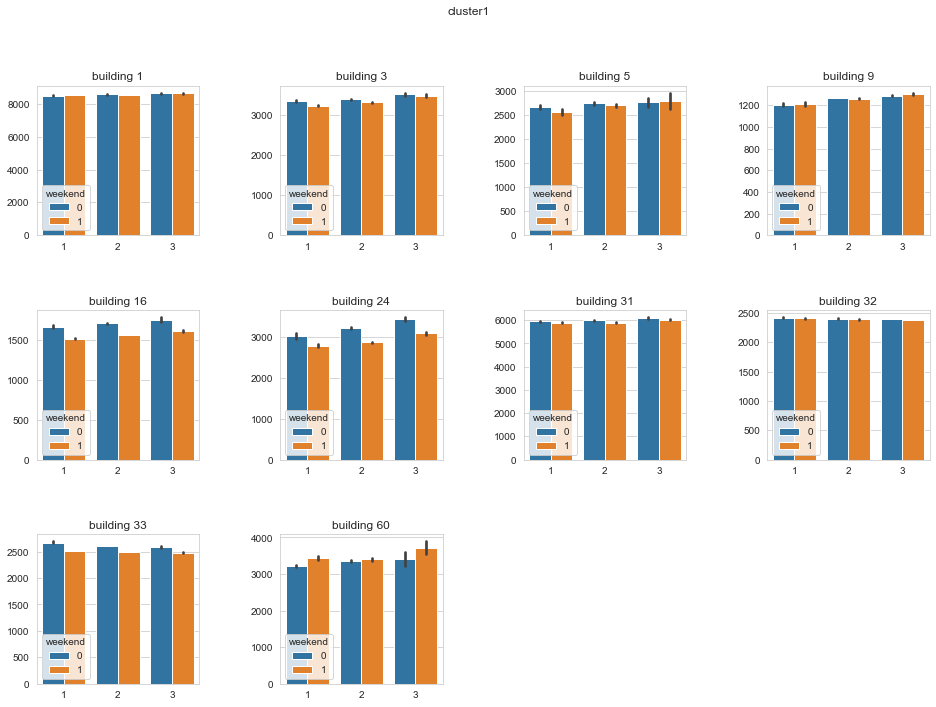

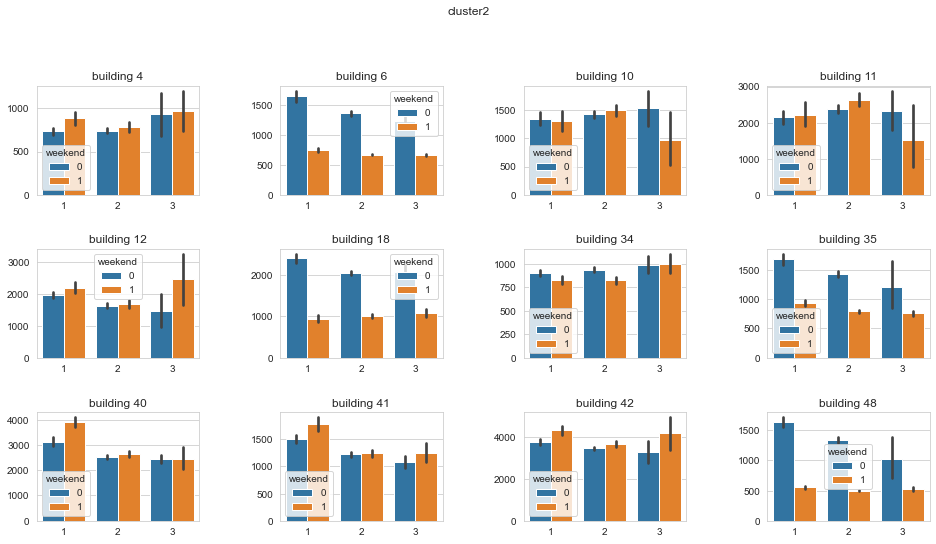

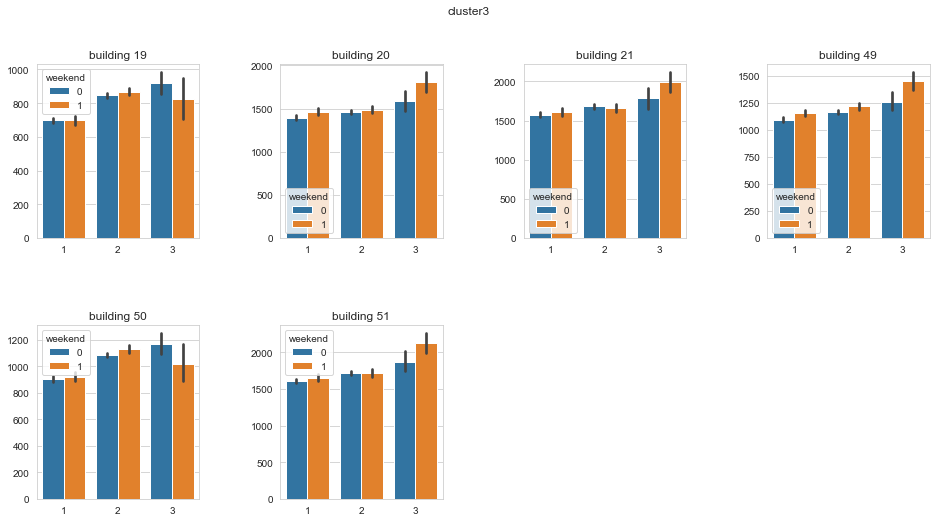

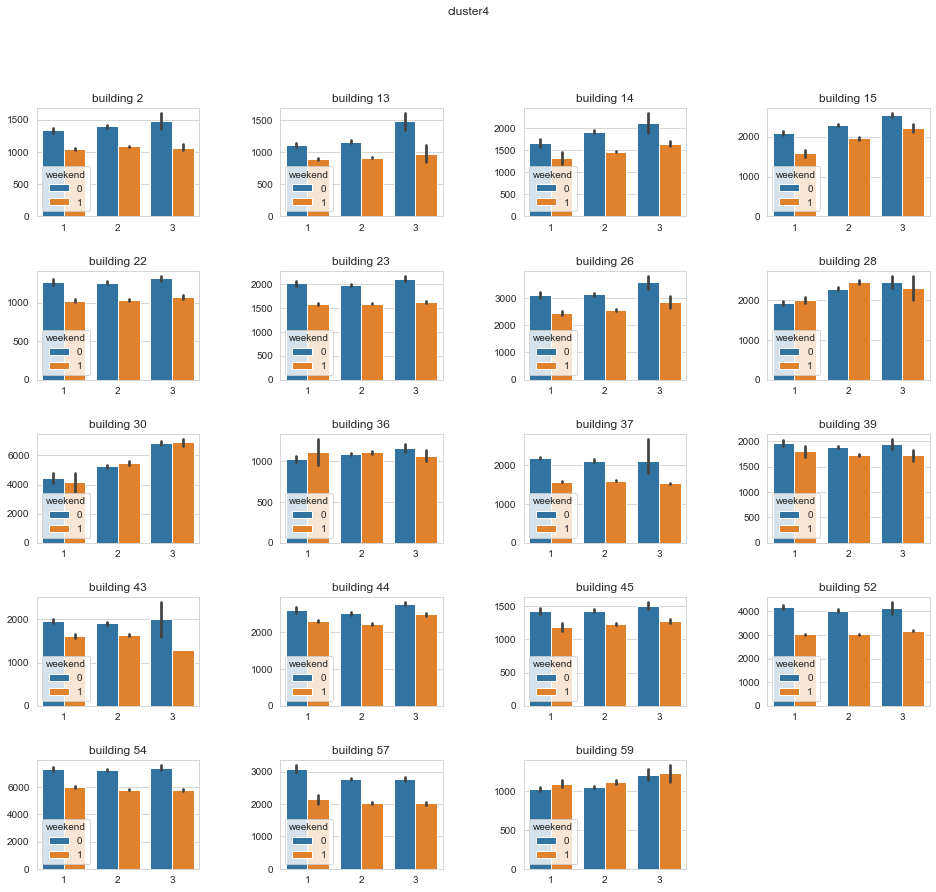

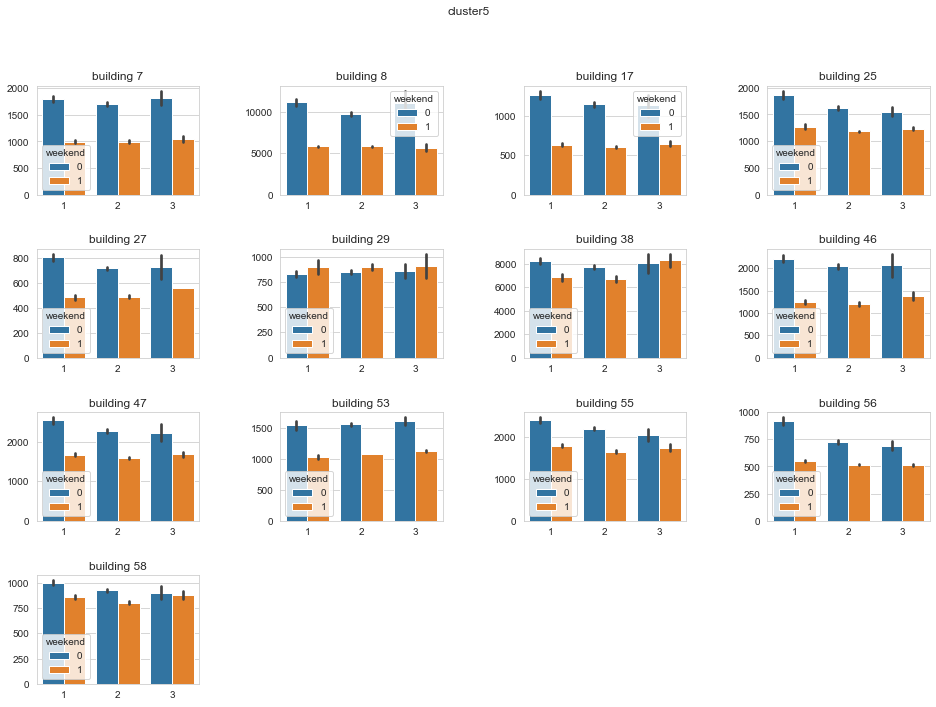

In [128]:
for c in range(1,6):
    temp_1 = df[df.cluster == c]
    nums = np.unique(temp_1.num)
    n_nums = len(nums)
    fig = plt.figure(figsize = (16, 3*(n_nums//5 + 1)+2))
    plt.suptitle(f'cluster{c}')
    for i, num in enumerate(nums):
        temp_2 = temp_1[temp_1.num == num]
        plt.subplot(n_nums//4+1,4, i+1)
        sns.barplot(data = temp_2, x='env_temp_d', y='target', hue= 'weekend')
        plt.title(f'building {num}')
        plt.ylabel('')
        plt.xlabel('')
        plt.subplots_adjust(wspace = 0.5, hspace = 0.5)